##  Case Study - Credit Default Prediction 


- **Business Context:** 
    - Banks primarily make money by lending it to people. When they lend money to people who repay it on time with good interest, the bank earns more revenue.

    - The more a bank can identify borrowers who may have trouble repaying their loans, the better it is for the bank's lending business. This can lead to increased revenue and a better reputation in the market compared to competitors.

- **Delinquent vs. Default:** 
    - Delinquent means a borrower is behind on payments by a few months, while default means they've been unable to pay for an extended period and are unlikely to repay.

    - We gather information about borrowers, including their age, monthly income, dependents, and historical data like debt ratio, amount owed relative to credit limit, and the number of recent defaults (1, 2, or 3 months).

    - We use this information to predict if a borrower is likely to experience serious delinquency in the next two years. These predictions help banks take necessary actions.

- **Objective:** 
    - Build a model using borrower profiles and historical records to predict serious delinquency in the next two years.

---


In [44]:
# Importing required libraries
# tested on python=3.8.10
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis
from scipy import stats, special
from scipy.stats import skew
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

In [45]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

In [46]:
# Display all rows and columns of a dataframe
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 1000)

In [47]:
# Importing ML algorithms
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score, precision_score, f1_score,roc_auc_score,auc,roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [48]:
# Importing tensorflow and keras modules
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

---

### Loading dataset

In [49]:
# Reading the training dataset
df = pd.read_csv('../input/cs-training.csv')

In [50]:
# No. of rows and the columns
df.shape

(150000, 12)

In [51]:
# Attribute information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [52]:
# Calculate the percentage of missing data for each feature
missing_percentage = (df.isnull().sum(axis=0) / len(df)) * 100

# Round the percentage values to two decimal places
missing_percentage = round(missing_percentage, 2)

missing_percentage


Unnamed: 0                               0.0
SeriousDlqin2yrs                         0.0
RevolvingUtilizationOfUnsecuredLines     0.0
age                                      0.0
NumberOfTime30-59DaysPastDueNotWorse     0.0
DebtRatio                                0.0
MonthlyIncome                           20.0
NumberOfOpenCreditLinesAndLoans          0.0
NumberOfTimes90DaysLate                  0.0
NumberRealEstateLoansOrLines             0.0
NumberOfTime60-89DaysPastDueNotWorse     0.0
NumberOfDependents                       3.0
dtype: float64

In [53]:
df.head()

Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [54]:
# Calculate the unique borrower proportion
unique_borrower_proportion = df['Unnamed: 0'].nunique() / len(df)

1.0

In [55]:
# Rename the 'Unnamed: 0' column to 'CustomerID'
df.rename(columns={'Unnamed: 0': 'CustomerID'}, inplace=True)


In [56]:
# Check unique values in the target variable
unique_values = df['SeriousDlqin2yrs'].unique()

# Calculate the percentage of borrowers falling into serious delinquency
percentage_delinquency = (df['SeriousDlqin2yrs'].sum() / len(df)) * 100

# Print unique values and the percentage of delinquency
print(unique_values)
print()
print('{}% of borrowers in serious delinquency'.format(percentage_delinquency))


[1 0]

6.683999999999999% of the borrowers falling in the serious delinquency 


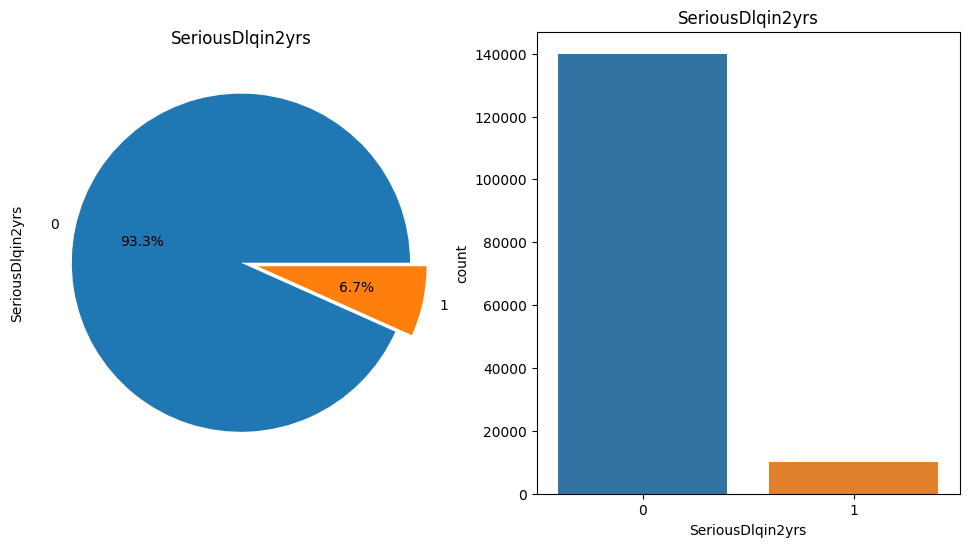

In [57]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a pie chart for 'SeriousDlqin2yrs' distribution
df['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')

# Create a countplot for 'SeriousDlqin2yrs' distribution
sns.countplot(x='SeriousDlqin2yrs', data=df, ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')

# Show the plots
plt.show()


In [58]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [59]:
df.describe()

CustomerID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866                              4.192781    2037.818523   
min         0.000000                              0.000000       0.000000   
25%        41.000000                              0.000000       0.175074   
50%        52.000000                              0.000000       0.366508   
75%        63.000000                              0.000000       0.868254   
max       109.000000                             98.000000  329664.000000   

       MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
count   1.202690e+05                    150000.000000   
mean    6.670221e+03                         8.452760   
std     1.438467e+04                         5.145951   
min     0.000000e+00                         0.000000   
25%     3.400000e+03                         5.000000   
50%     5.400000e+03                         8.000000   
75%     8.249000e+03                        11.000000   
max     3.008750e+06                        58.000000   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
count            150000.000000                 150000.000000   
mean                  0.265973                      1.018240   
std                   4.169304                      1.129771   
min                   0.000000                      0.000000   
25%                   0.000000                      0.000000   
50%                   0.000000                      1.000000   
75%                   0.000000                      2.000000   
max                  98.000000                     54.000000   

       NumberOfTime60-89DaysPastDueNotWorse  NumberOfDependents  
count                         150000.000000       146076.000000  
mean                               0.240387            0.757222  
std                                4.155179            1.115086  
min                                0.000000            0.000000  
25%                                0.000000            0.000000  
50%                                0.000000            0.000000  
75%                                0.000000            1.000000  
max                               98.000000           20.000000

---

### Splitting dataset

- We'll divide the dataset into two parts:
  - A training set (80%) for building the model using statistical and machine learning techniques.
  - A test set (20%) to make predictions and assess the model's performance.

In [60]:
# Remove 'SeriousDlqin2yrs' column
data = df.drop(columns=['SeriousDlqin2yrs'], axis=1)

y = df['SeriousDlqin2yrs']

In [63]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
df_test, df_train, y_test, y_train = train_test_split(data, y, test_size=0.8, random_state=42, stratify=y)

# Display the shapes of the resulting sets
df_test.shape, df_train.shape


((30000, 11), (120000, 11))

In [64]:
# Calculate and print the event rate in the training dataset
print('Event rate in the training dataset: ', np.mean(y_train))
print()

# Calculate and print the event rate in the test dataset
print('Event rate in the test dataset: ', np.mean(y_test))
print()

# Calculate and print the event rate in the entire dataset
print('Event rate in the entire dataset: ', np.mean(y))


Event rate in the training dataset :  0.06684166666666666

Event rate in the test dataset :  0.06683333333333333

Event rate in the entire dataset :  0.06684


* Event rate/Default Rate is maintainted in the training and test dataset after splitting in line with the entire dataset

In [65]:
# Combine features and target in 'train' DataFrame, and check its shape
train = pd.concat([df_train, y_train], axis=1)
train.shape


(120000, 12)

In [66]:
# Combine test features and target, and check its shape
test = pd.concat([df_test, y_test], axis=1)
test.shape


(30000, 12)

---

### Univariate Analysis using Training Numerical dataset

In [67]:
# Plot histogram and boxplot for the given column
def plot_hist_boxplot(column):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5)

    # Plot histogram
    sns.distplot(train[train[column].notnull()][column], ax=ax1)

    # Plot boxplot
    sns.boxplot(y=train[train[column].notnull()][column], ax=ax2)

    # Print skewness and kurtosis
    print("Skewness:", skew(train[train[column].notnull()][column]))
    print("Kurtosis:", kurtosis(train[train[column].notnull()][column]))

    # Display the plots
    plt.show()


In [68]:
# Plot countplot and boxplot for the given column
def plot_count_boxplot(column):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

    # Create a countplot
    sns.countplot(train[train[column].notnull()][column], ax=ax1)

    # Create a boxplot
    sns.boxplot(y=train[train[column].notnull()][column], ax=ax2)

    # Calculate and print skewness
    print("Skewness:", skew(train[train[column].notnull()][column]))

    # Calculate and print kurtosis
    print("Kurtosis:", kurtosis(train[train[column].notnull()][column]))

    # Display the plots
    plt.show()


skewness :  104.51383625945637
kurtosis :  16544.639125909292


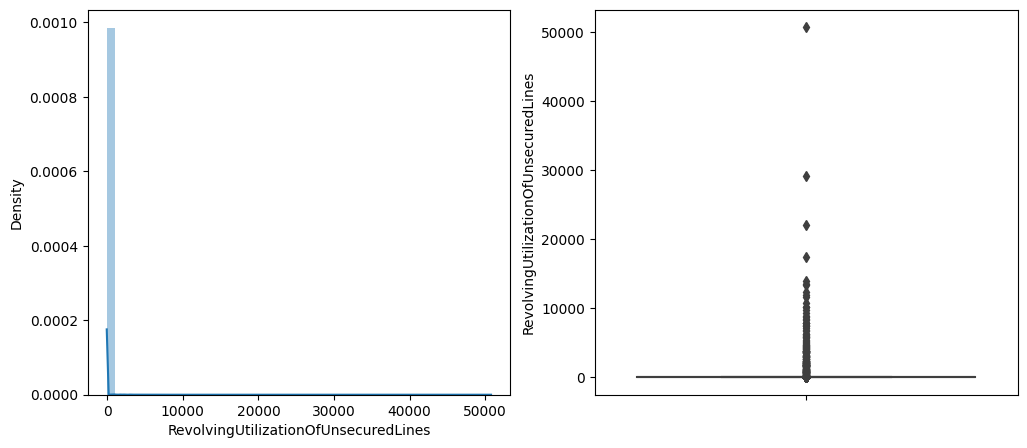

In [69]:
plot_hist_boxplot('RevolvingUtilizationOfUnsecuredLines')

skewness :  0.1883379862757487
kurtosis :  -0.4989842553901078


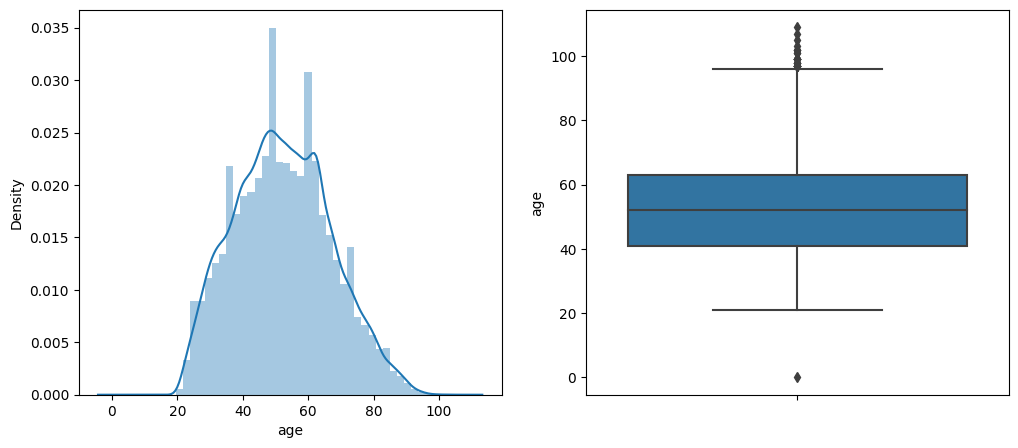

In [70]:
plot_hist_boxplot('age')

skewness :  95.78845308753385
kurtosis :  14212.893907176613


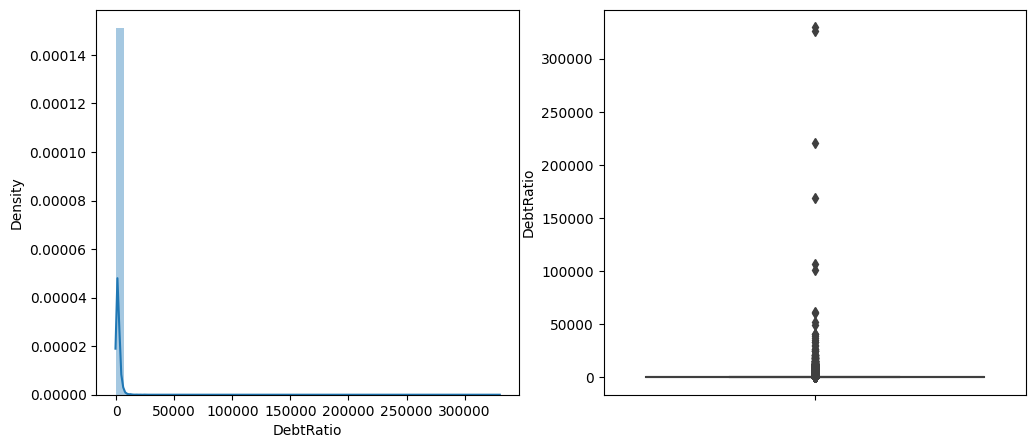

In [71]:
plot_hist_boxplot('DebtRatio')

skewness :  117.98020100894865
kurtosis :  19658.712451467025


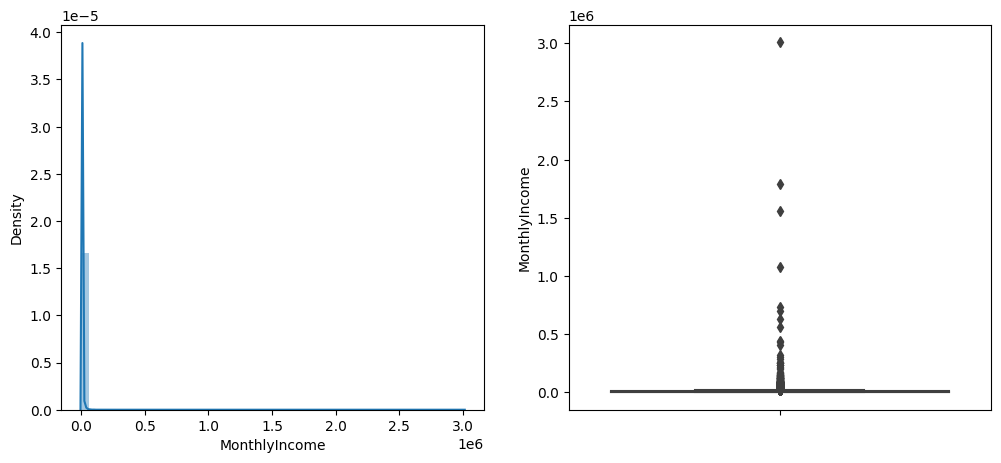

In [72]:
plot_hist_boxplot('MonthlyIncome')

skewness :  1.2145901173605567
kurtosis :  3.114685912968633


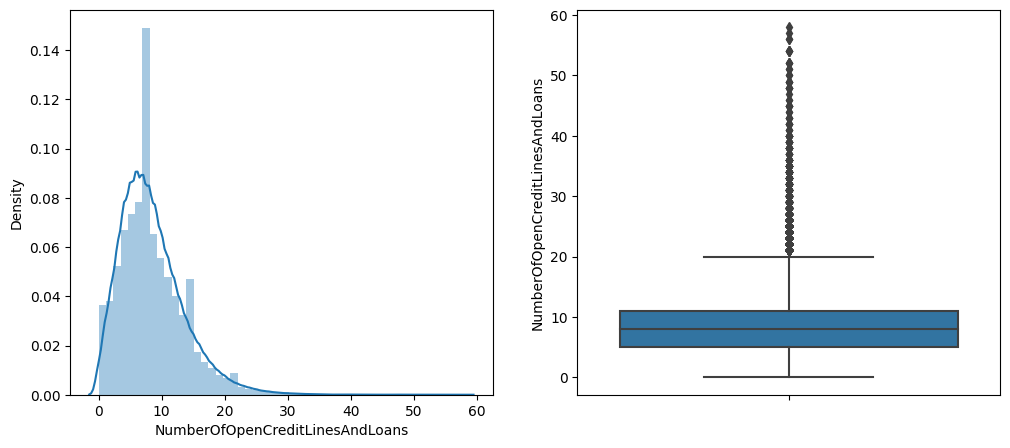

In [73]:
plot_hist_boxplot('NumberOfOpenCreditLinesAndLoans')

skewness :  3.635466187390173
kurtosis :  67.79380246787325


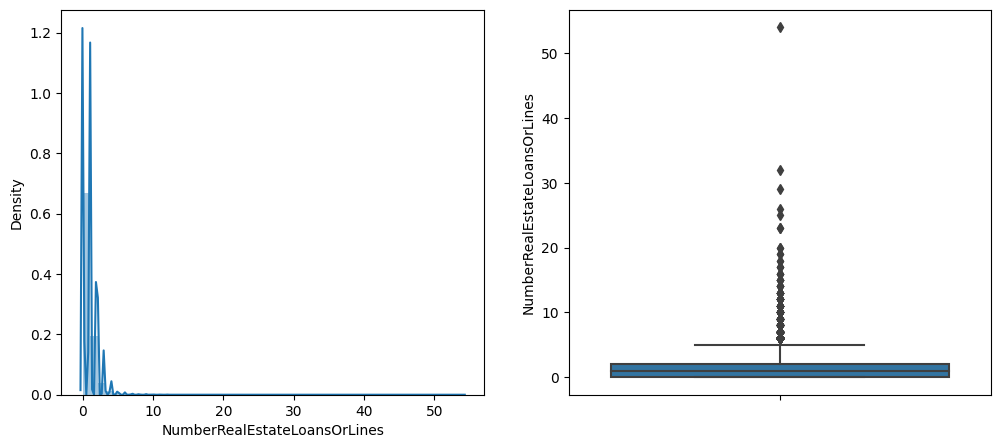

In [74]:
plot_hist_boxplot('NumberRealEstateLoansOrLines')

skewness :  1.5991497659767622
kurtosis :  3.1681417562669285


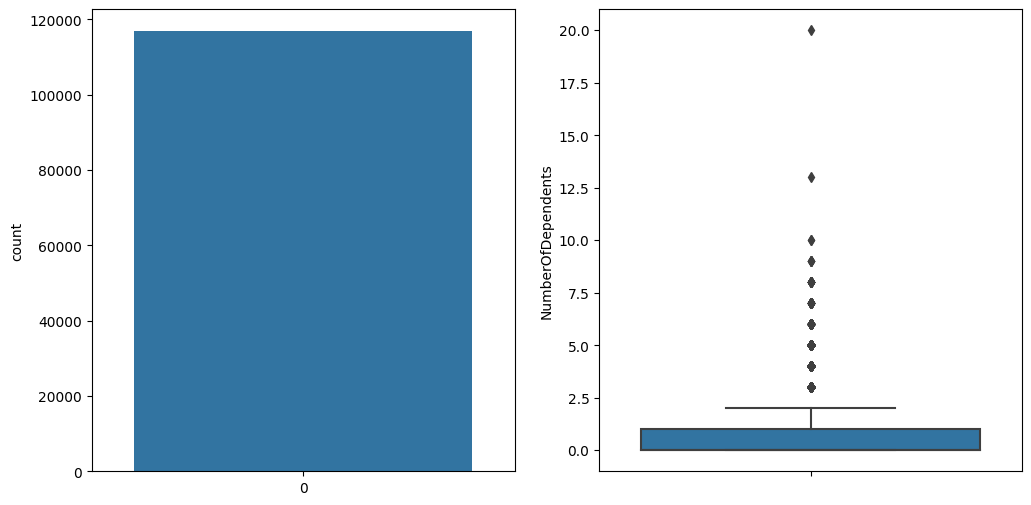

In [75]:
plot_count_boxplot('NumberOfDependents')

skewness :  22.56005009391927
kurtosis :  520.5861400129826


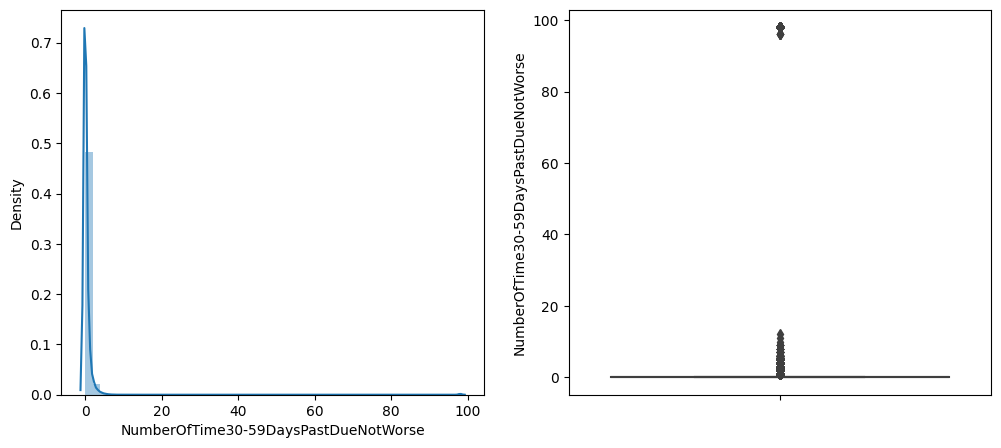

In [76]:
plot_hist_boxplot('NumberOfTime30-59DaysPastDueNotWorse')

skewness :  23.287569502079286
kurtosis :  543.6121286456557


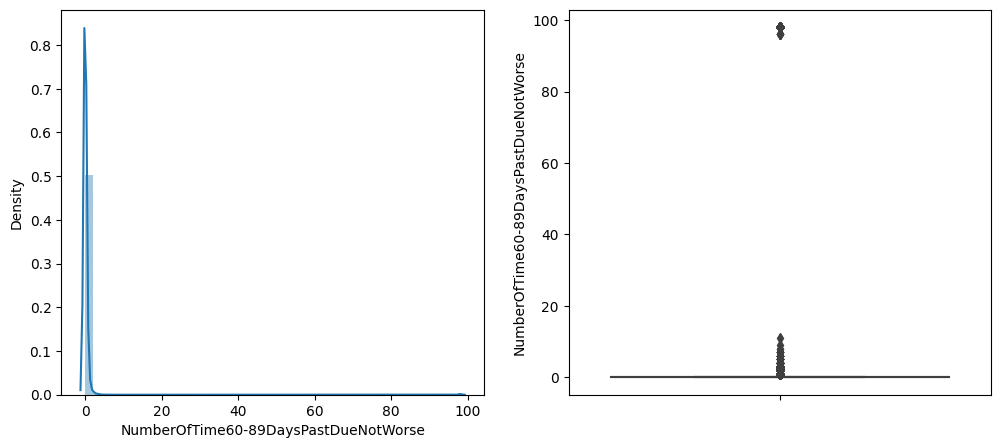

In [77]:
plot_hist_boxplot('NumberOfTime60-89DaysPastDueNotWorse')

skewness :  23.0371547196054
kurtosis :  535.4918343524778


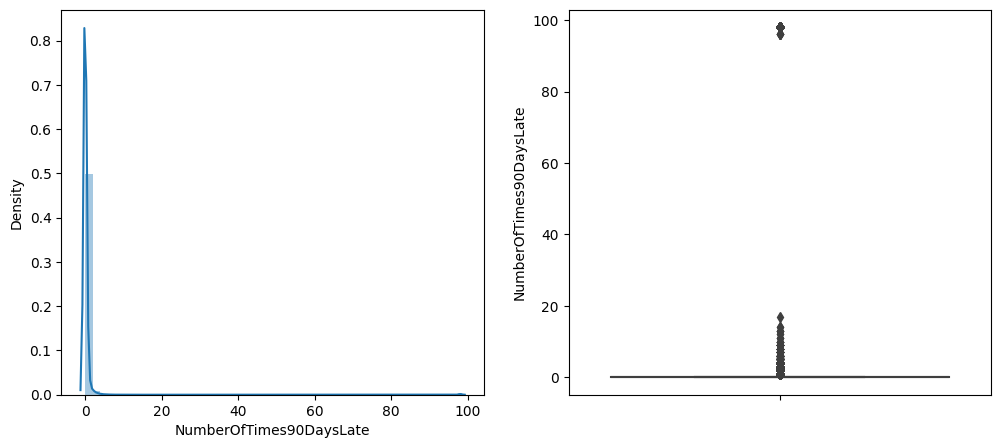

In [78]:
plot_hist_boxplot('NumberOfTimes90DaysLate')

In [79]:
# List of columns for statistical analysis
cols_for_stats = ['RevolvingUtilizationOfUnsecuredLines', 'age',
   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
   'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
   'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
   'NumberOfDependents']


In [80]:
# Initialize lists for skewness and kurtosis
skewness = []
kurt = []

# Calculate skewness and kurtosis for specified columns
for column in cols_for_stats:
    skewness.append(skew(train[train[column].notnull()][column]))
    kurt.append(kurtosis(train[train[column].notnull()][column]))

# Create a DataFrame with skewness and kurtosis, indexed by column names
stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt}, index=cols_for_stats)

# Sort the DataFrame by 'Skewness' in descending order
stats.sort_values(by=['Skewness'], ascending=False)


Skewness      Kurtosis
MonthlyIncome                         117.980201  19658.712451
RevolvingUtilizationOfUnsecuredLines  104.513836  16544.639126
DebtRatio                              95.788453  14212.893907
NumberOfTime60-89DaysPastDueNotWorse   23.287570    543.612129
NumberOfTimes90DaysLate                23.037155    535.491834
NumberOfTime30-59DaysPastDueNotWorse   22.560050    520.586140
NumberRealEstateLoansOrLines            3.635466     67.793802
NumberOfDependents                      1.599150      3.168142
NumberOfOpenCreditLinesAndLoans         1.214590      3.114686
age                                     0.188338     -0.498984

* * Data distribution in the columns are highly right skewed with very high kurtosis value showing extreme outliers in those columns
* * Except age which is little normally distributed

---

## Data Cleaning

#### Outlier Treatment

- **Observation:** After analyzing the boxplot graphs, it is evident that:

  - In the columns NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, and NumberOfTimes90DaysLate, there is a common occurrence of delinquency values that exceed 90.
  
- **Action:** We will address the outliers in the following columns:

  - NumberOfTime30-59DaysPastDueNotWorse
  - NumberOfTime60-89DaysPastDueNotWorse
  - NumberOfTimes90DaysLate


In [81]:
# Unique values in '30-59 Days' when >= 90
print("Unique values in '30-59 Days' (>=90):", np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTime30-59DaysPastDueNotWorse']))

# Unique values in '60-89 Days' when '30-59 Days' >= 90
print("Unique values in '60-89 Days' (when '30-59 Days' >= 90):", np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTime60-89DaysPastDueNotWorse']))

# Unique values in '90 Days' when '30-59 Days' >= 90
print("Unique values in '90 Days' (when '30-59 Days' >= 90):", np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTimes90DaysLate']))

# Unique values in '30-59 Days' when < 90
print("Unique values in '30-59 Days' (< 90):", np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime30-59DaysPastDueNotWorse']))

# Unique values in '60-89 Days' when '30-59 Days' < 90
print("Unique values in '60-89 Days' (when '30-59 Days' < 90):", np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime60-89DaysPastDueNotWorse']))

# Unique values in '90 Days' when '30-59 Days' < 90
print("Unique values in '90 Days' (when '30-59 Days' < 90):", np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTimes90DaysLate']))

# Proportion of positive class with special values 96/98
print("Proportion of positive class with special 96/98 values:", round(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/len(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2), '%")


Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]
Proportion of positive class with special 96/98 values: 55.56 %


- **Observation:** In the 'NumberOfTime30-59DaysPastDueNotWorse' column, when the records exceed 90, it's evident that the corresponding values in other columns tracking the number of times payments are past due X days are also the same. These cases are being categorized as special labels due to an unusually high positive class proportion of 55.56%.

- **Action:** The values 96 and 98 are considered accounting errors. Therefore, we will replace them with the maximum values just before 96, which are 12 for 'NumberOfTime30-59DaysPastDueNotWorse,' 11 for 'NumberOfTime60-89DaysPastDueNotWorse,' and 17 for 'NumberOfTimes90DaysLate.'


In [82]:
# Replace values >= 90 with 12 in 'NumberOfTime30-59DaysPastDueNotWorse'
train.loc[train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 12

# Replace values >= 90 with 11 in 'NumberOfTime60-89DaysPastDueNotWorse'
train.loc[train['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11

# Replace values >= 90 with 17 in 'NumberOfTimes90DaysLate'
train.loc[train['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17


In [83]:
# Unique values in 'NumberOfTime30-59DaysPastDueNotWorse'
print("Unique values in 30-59Days:", np.unique(train['NumberOfTime30-59DaysPastDueNotWorse']))

# Unique values in 'NumberOfTime60-89DaysPastDueNotWorse'
print("Unique values in 60-89Days:", np.unique(train['NumberOfTime60-89DaysPastDueNotWorse']))

# Unique values in 'NumberOfTimes90DaysLate'
print("Unique values in 90Days:", np.unique(train['NumberOfTimes90DaysLate']))


Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]


In [84]:
# Unique values in '30-59 Days' when >= 90 in the test set
print("Unique values in '30-59 Days' (>=90) in test:", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]['NumberOfTime30-59DaysPastDueNotWorse']))

# Unique values in '60-89 Days' when '30-59 Days' >= 90 in the test set
print("Unique values in '60-89 Days' (when '30-59 Days' >= 90) in test:", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]['NumberOfTime60-89DaysPastDueNotWorse']))

# Unique values in '90 Days' when '30-59 Days' >= 90 in the test set
print("Unique values in '90 Days' (when '30-59 Days' >= 90) in test:", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]['NumberOfTimes90DaysLate']))

# Unique values in '30-59 Days' when < 90 in the test set
print("Unique values in '30-59 Days' (< 90) in test:", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] < 90]['NumberOfTime30-59DaysPastDueNotWorse']))

# Unique values in '60-89 Days' when '30-59 Days' < 90 in the test set
print("Unique values in '60-89 Days' (when '30-59 Days' < 90) in test:", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] < 90]['NumberOfTime60-89DaysPastDueNotWorse']))

# Unique values in '90 Days' when '30-59 Days' < 90 in the test set
print("Unique values in '90 Days' (when '30-59 Days' < 90) in test:", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] < 90]['NumberOfTimes90DaysLate']))


Unique values in '30-59 Days' values that are more than or equal to 90: [98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [0 1 2 3 4 5 6 7]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 15]


* *Since, these values exist in Test Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 13, 7 and 15.*

In [85]:
# Replace values >= 90 with 13 in 'NumberOfTime30-59DaysPastDueNotWorse' in the test set
test.loc[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13

# Replace values >= 90 with 7 in 'NumberOfTime60-89DaysPastDueNotWorse' in the test set
test.loc[test['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 7

# Replace values >= 90 with 15 in 'NumberOfTimes90DaysLate' in the test set
test.loc[test['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 15

# Unique values in 'NumberOfTime30-59DaysPastDueNotWorse' after replacement
print("Unique values in '30-59Days' after replacement in test:", np.unique(test['NumberOfTime30-59DaysPastDueNotWorse']))

# Unique values in 'NumberOfTime60-89DaysPastDueNotWorse' after replacement
print("Unique values in '60-89Days' after replacement in test:", np.unique(test['NumberOfTime60-89DaysPastDueNotWorse']))

# Unique values in 'NumberOfTimes90DaysLate' after replacement
print("Unique values in '90Days' after replacement in test:", np.unique(test['NumberOfTimes90DaysLate']))


Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in 60-89Days [0 1 2 3 4 5 6 7]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 15]


 * *Checking for * **DebtRatio** and * **RevolvingUtilizationOfUnsecuredLines.***

In [86]:
# Print summary statistics for 'DebtRatio' and 'RevolvingUtilizationOfUnsecuredLines' in the training dataset
print('Debt Ratio: \n', train['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n', train['RevolvingUtilizationOfUnsecuredLines'].describe())


Debt Ratio: 
 count    120000.000000
mean        350.913763
std        1985.649364
min           0.000000
25%           0.174335
50%           0.365643
75%           0.866853
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines: 
 count    120000.000000
mean          5.986096
std         251.444207
min           0.000000
25%           0.029737
50%           0.154659
75%           0.559328
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


#### Debt Ratio

* As you can see data is right skewed. So, our main aim would be to check the potential outliers beyond 95% quantiles. However, since our data is 120,000, let's consider 95% and 97.5% quantiles for our further analysis.

In [87]:
# Get summary statistics for 'SeriousDlqin2yrs' and 'MonthlyIncome' for rows where 'DebtRatio' is >= 95th percentile
train[train['DebtRatio'] >= train['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs', 'MonthlyIncome']].describe()


SeriousDlqin2yrs  MonthlyIncome
count       6002.000000     308.000000
mean           0.054315       0.077922
std            0.226658       0.268485
min            0.000000       0.000000
25%            0.000000       0.000000
50%            0.000000       0.000000
75%            0.000000       0.000000
max            1.000000       1.000000

Here we can observe:

- Out of 6002 customers falling in the last 5 percentile of the data i.e. the number of times their debt is higher than their income, only 308 have Monthly Income values.

- The Max for Monthly Income is 1 and Min is 0 which makes us wonder that are data entry errors. Let's check whether the Serious Delinquency in 2 years and Monthly Income values are equal.

In [88]:
# Count the number of rows where 'DebtRatio' > 95th percentile and 'SeriousDlqin2yrs' is equal to 'MonthlyIncome'
train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome'])].shape[0]


271

* Hence, our suspects are true and there are 271 out of 308 rows where Monthly Income is equal to the Serious Delinquencies in 2 years. Hence we will remove these 271 outliers from our analysis as their current values aren't useful for our predictive modelling and will add to the bias and variance.

In [89]:
# Create a new dataset 'new_train' by excluding rows where 'DebtRatio' > 95th percentile and 'SeriousDlqin2yrs' is equal to 'MonthlyIncome'
new_train = train[-((train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome']))]
new_train.shape


(119729, 12)

* **Revolving Utilization of Unsecured Lines**

* This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [90]:
# Get summary statistics for 'new_train' where 'RevolvingUtilizationOfUnsecuredLines' is greater than 10
new_train[new_train['RevolvingUtilizationOfUnsecuredLines'] > 10].describe()


CustomerID  RevolvingUtilizationOfUnsecuredLines         age  \
count     187.000000                            187.000000  187.000000   
mean    78422.989305                           3634.411136   50.989305   
std     40921.820372                           5247.138619   14.651136   
min       294.000000                             14.000000   24.000000   
25%     44759.500000                            953.000000   39.000000   
50%     80200.000000                           2120.000000   49.000000   
75%    113817.000000                           4240.000000   63.000000   
max    149161.000000                          50708.000000   87.000000   

       NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
count                            187.000000   187.000000     133.000000   
mean                               0.176471   522.932048    9020.067669   
std                                0.544654  1205.632700    7156.622316   
min                                0.000000     0.000800       0.000000   
25%                                0.000000     0.217823    5000.000000   
50%                                0.000000     0.381491    7083.000000   
75%                                0.000000    90.000000   10575.000000   
max                                3.000000  6820.000000   44472.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       187.000000               187.000000   
mean                          5.614973                 0.080214   
std                           3.100709                 0.646732   
min                           1.000000                 0.000000   
25%                           4.000000                 0.000000   
50%                           5.000000                 0.000000   
75%                           7.000000                 0.000000   
max                          21.000000                 8.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                    187.000000                            187.000000   
mean                       1.208556                              0.080214   
std                        1.094626                              0.603737   
min                        0.000000                              0.000000   
25%                        1.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                        9.000000                              7.000000   

       NumberOfDependents  SeriousDlqin2yrs  
count          179.000000        187.000000  
mean             0.687151          0.048128  
std              1.045269          0.214612  
min              0.000000          0.000000  
25%              0.000000          0.000000  
50%              0.000000          0.000000  
75%              1.000000          0.000000  
max              4.000000          1.000000

* Despite owing thousands, out of these these 187 people ,less than 10 people are falling in the serious delinquency which means this might be another error. Even if it is not an error, these numbers will add huge bias and variance to our final predictions. Therefore, the best decision is to remove these values.

In [91]:
# Filter 'new_train' to keep only rows where 'RevolvingUtilizationOfUnsecuredLines' is less than or equal to 10
new_train = new_train[new_train['RevolvingUtilizationOfUnsecuredLines'] <= 10]
new_train.shape


(119542, 12)

In [92]:
# Filter 'test' to keep only rows where 'RevolvingUtilizationOfUnsecuredLines' is less than or equal to 10
new_test = test[test['RevolvingUtilizationOfUnsecuredLines'] <= 10]
new_test.shape


(29946, 12)

* **Age**

In [93]:
# Get summary statistics for the 'age' and 'SeriousDlqin2yrs' columns in 'new_train'
new_train[['age', 'SeriousDlqin2yrs']].describe()


age  SeriousDlqin2yrs
count  119542.000000     119542.000000
mean       52.296130          0.067006
std        14.775558          0.250033
min         0.000000          0.000000
25%        41.000000          0.000000
50%        52.000000          0.000000
75%        63.000000          0.000000
max       109.000000          1.000000

* It can be observed that the data includes a record with age = 0 which is not a valid age ,updating the record with mode age.

In [94]:
# Filter 'new_train' to select rows where 'age' is less than 1
new_train[new_train['age'] < 1]


CustomerID  RevolvingUtilizationOfUnsecuredLines  age  \
65695       65696                                   1.0    0   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
65695                                     1   0.436927         6000.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
65695                                6                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
65695                             2                                     0   

       NumberOfDependents  SeriousDlqin2yrs  
65695                 2.0                 0

* We will be replacing the error/odd value with the mode

In [95]:
# Replace 'age' values equal to 0 with the mode (most frequent value) of 'age' in 'new_train'
new_train.loc[new_train['age'] == 0, 'age'] = new_train['age'].mode()[0]


In [96]:
new_train['age'].min()

21

In [97]:
# Filter 'new_test' to select rows where 'age' is less than 1
new_test[new_test['age'] < 1]


Empty DataFrame
Columns: [CustomerID, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents, SeriousDlqin2yrs]
Index: []

* No such discrepancy is found in the test dataset

---

### Missing Value Treatment

- Since MonthlyIncome is an integer value, we will replace the nulls with the median values instead of mean as it was heavily right skewed.

- Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. 
Filling either by mode which is 0 or by the above assumption is the same.Therefore, we fill them with zeros.

In [98]:
# Define a function to handle missing data by calculating the percentage of null values in each column
def MissingHandler(df):
    DataMissing = df.isnull().sum() * 100 / len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls': DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls', ascending=False, inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls'] > 0]

# MissingHandler(new_train)


In [99]:
# Fill missing values in 'MonthlyIncome' with the median value in 'new_train'
new_train['MonthlyIncome'].fillna(new_train['MonthlyIncome'].median(), inplace=True)

# Fill missing values in 'NumberOfDependents' with 0 in 'new_train'
new_train['NumberOfDependents'].fillna(0, inplace=True)


* **Filling missing values with the same logic on the validation and the test dataset**

In [100]:
# Fill missing values in 'MonthlyIncome' with the median value in 'new_test'
new_test['MonthlyIncome'].fillna(new_test['MonthlyIncome'].median(), inplace=True)

# Fill missing values in 'NumberOfDependents' with 0 in 'new_test'
new_test['NumberOfDependents'].fillna(0, inplace=True)


#### Rechecking Null

In [101]:
MissingHandler(new_train)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [102]:
MissingHandler(new_test)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [103]:
MissingHandler(df_test)

Percentage Nulls
MonthlyIncome              19.943333
NumberOfDependents          2.643333

---

### Correlation Plot

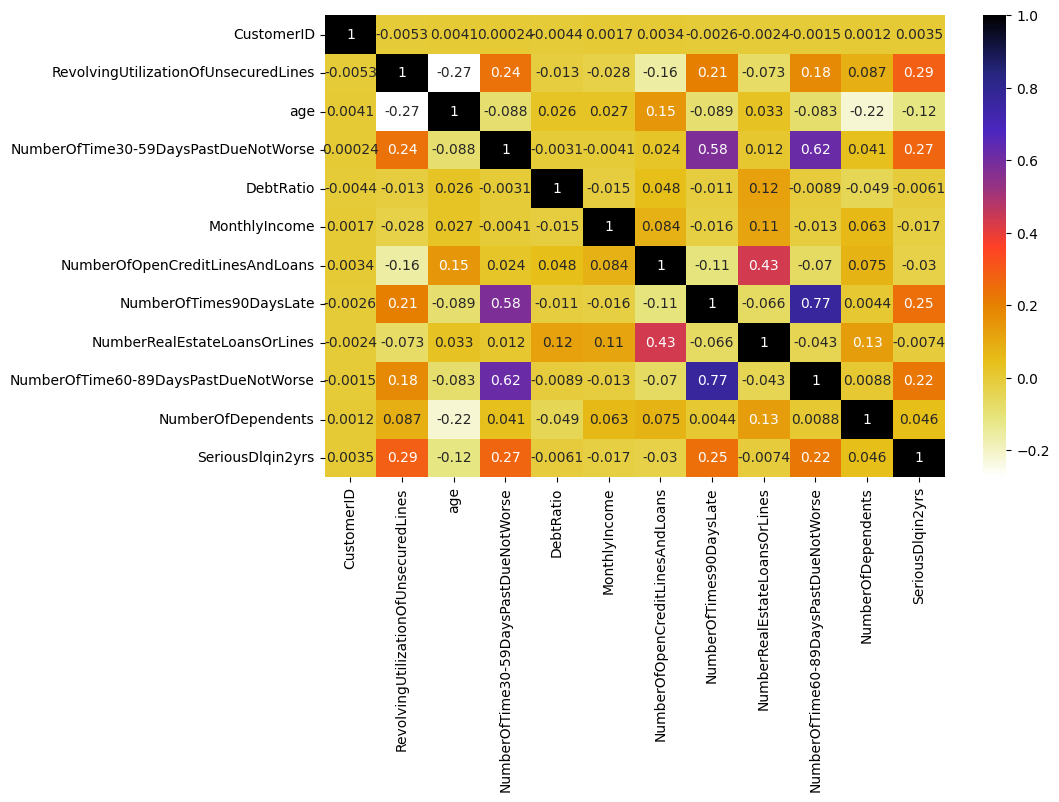

In [104]:
# Create a heatmap to visualize the correlation matrix of the 'new_train' dataset
plt.figure(figsize=(10,6))
sns.heatmap(new_train.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()


- From the correlation heatmap above, we can see the most correlated values to SeriousDlqin2yrs are NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate.

- Number of Open Credit Lines and Loans and Number of Real Estate Loans or Lines also have a significant correlation.

---

## Bivariate Analysis

In [105]:
# Create boxplot and violin plot for the relationship between 'col1' and 'col2' in 'new_train'
def boxplot_violinplot(col1, col2):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
    sns.boxplot(x=col1, y=col2, data=new_train, palette='Set3', ax=ax1)
    sns.violinplot(x=col1, y=col2, data=new_train, palette='Set3', ax=ax2)
    plt.show()


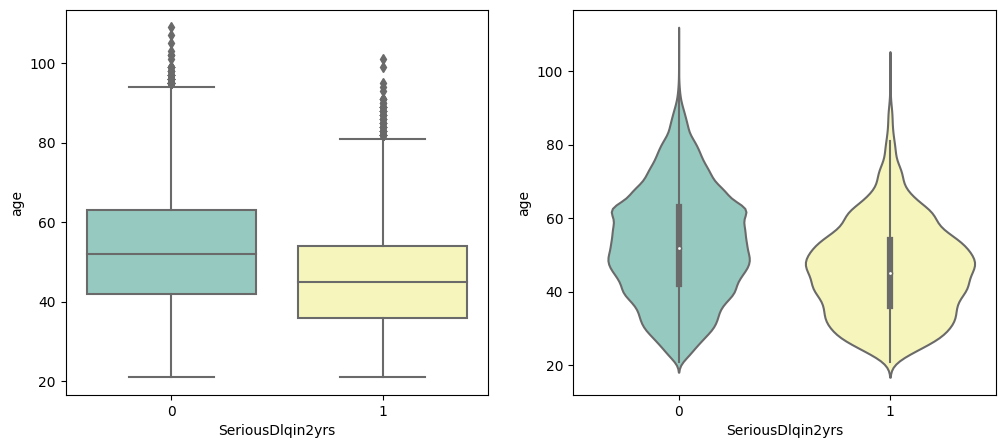

In [106]:
boxplot_violinplot('SeriousDlqin2yrs', 'age')

- Age has no significant on the target variable though most of the customers are in the mid 50 who has serious delinquency in 2 years

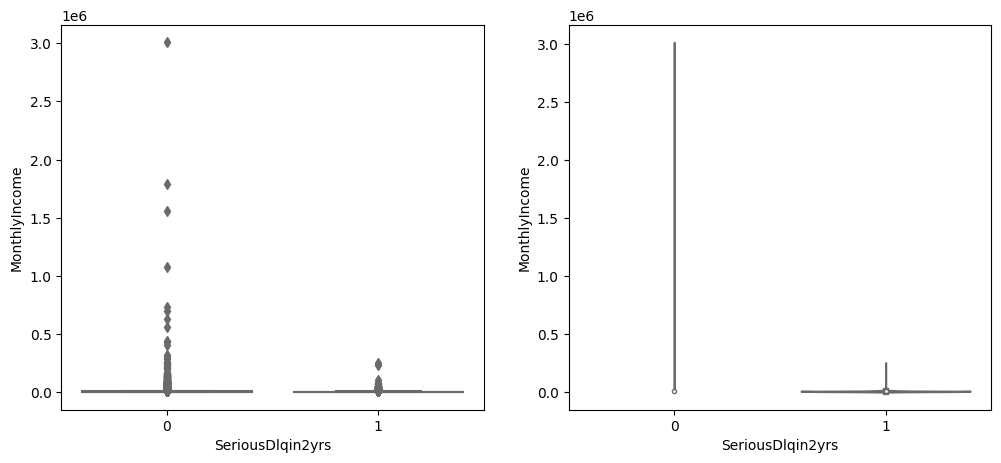

In [108]:
boxplot_violinplot('SeriousDlqin2yrs', 'MonthlyIncome')

- More or less similar relationship when target is 0 or 1

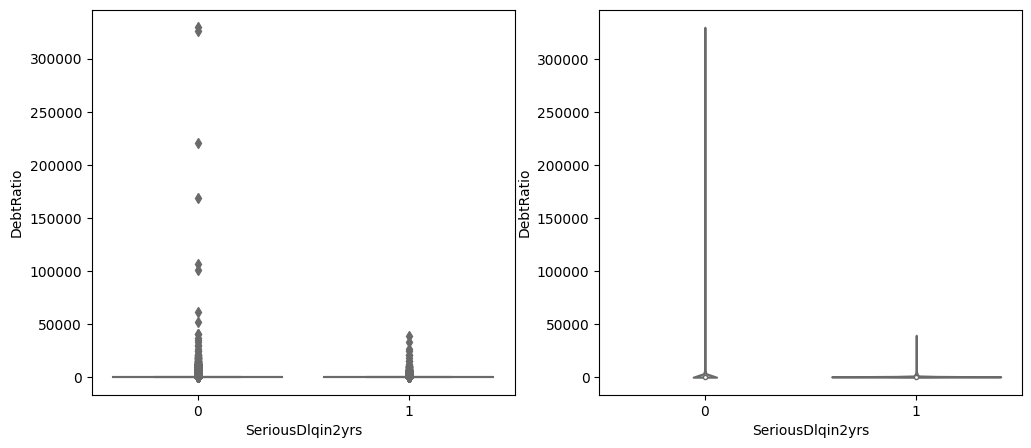

In [110]:
boxplot_violinplot('SeriousDlqin2yrs','DebtRatio')

- More or less similar relationship when target is 0 or 1

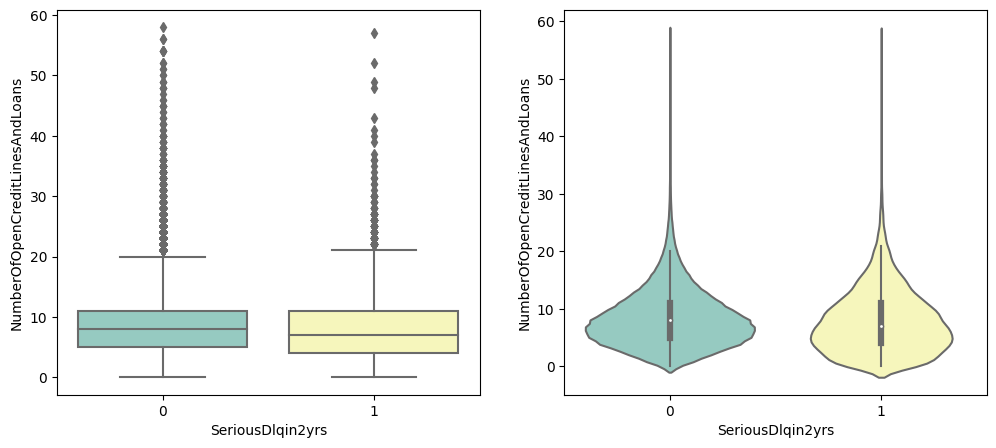

In [112]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfOpenCreditLinesAndLoans')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let me look into that by plotting the utlization ratio to default rate

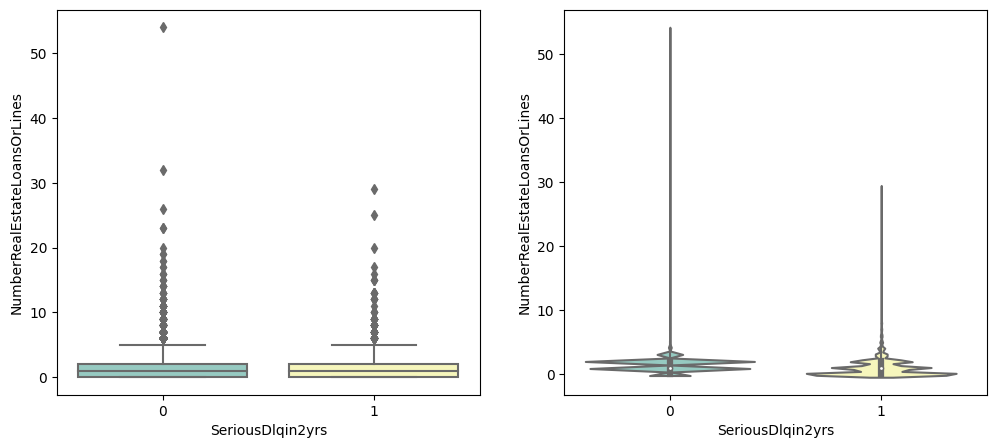

In [113]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberRealEstateLoansOrLines')

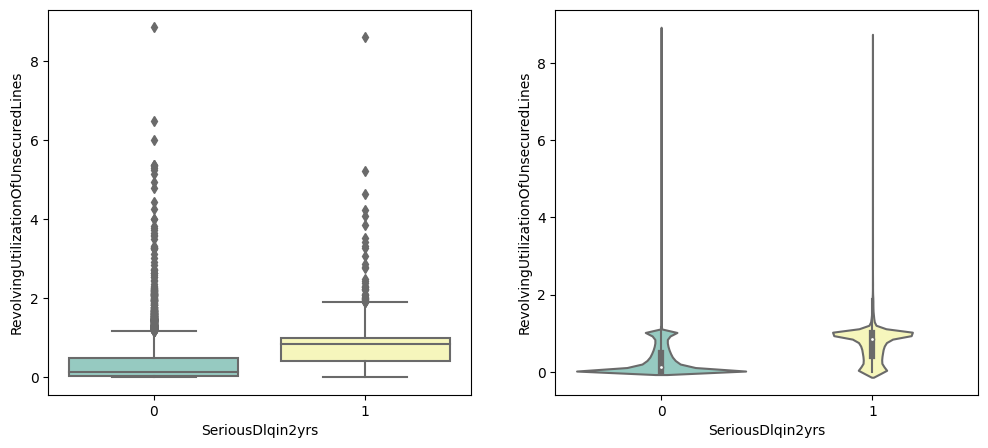

In [114]:
boxplot_violinplot('SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines')

- Feature description itself more the utlization of the credit resources or the ratio of amount owe to credit is more, serious delinquency is on a bit higher side

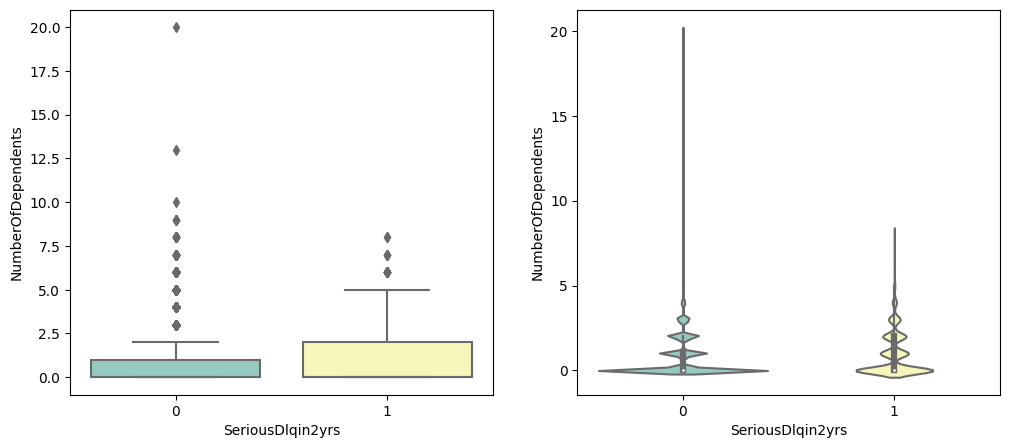

In [116]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfDependents')

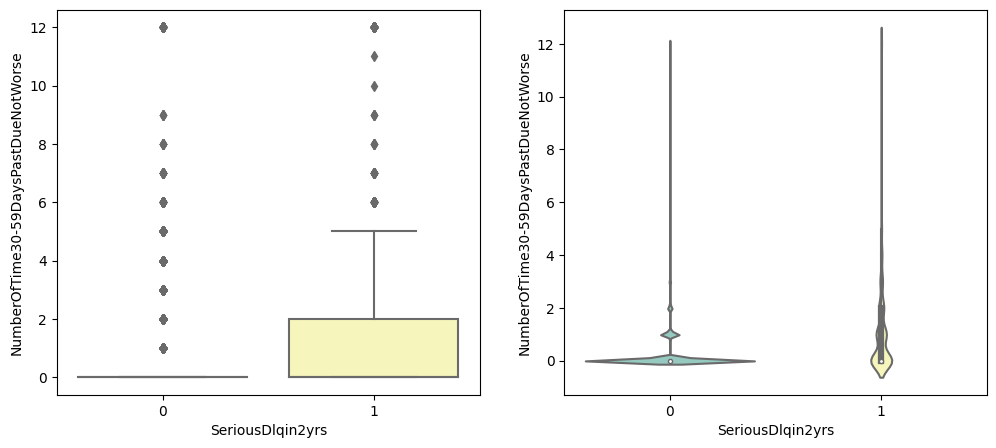

In [117]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse')

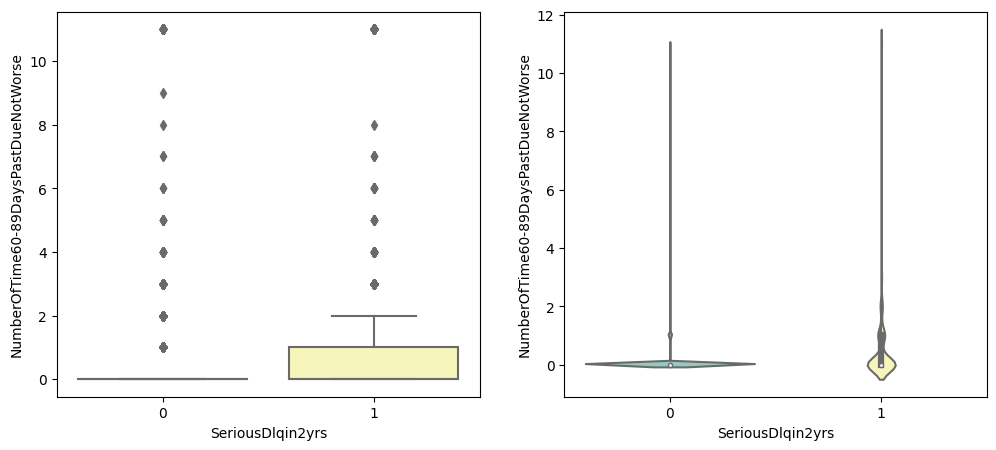

In [118]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse')

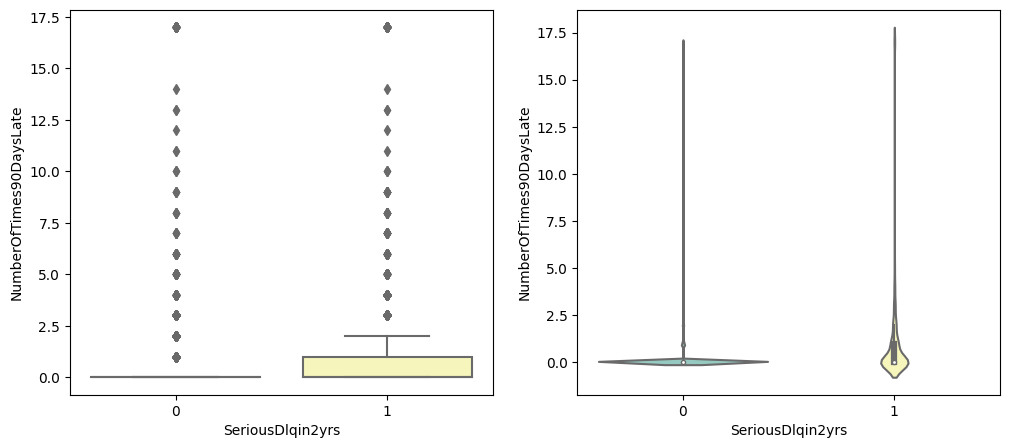

In [119]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTimes90DaysLate')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let me look into that by plotting the utlization ratio to default rate

---

## Feature Engineering

In [120]:
dataset = [new_train, new_test]

#### Making combined features

In [121]:
# Create new features 'CombinedPastDue' and 'CombinedCreditLoans' in each dataset in 'dataset'
for data in dataset:
    data['CombinedPastDue'] = data['NumberOfTime30-59DaysPastDueNotWorse'] + data['NumberOfTime60-89DaysPastDueNotWorse'] + data['NumberOfTimes90DaysLate']
    data['CombinedCreditLoans'] = data['NumberOfOpenCreditLinesAndLoans'] + data['NumberRealEstateLoansOrLines']

    
new_train.columns    

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans'],
      dtype='object')

#### Interaction of the features

In [122]:
# Create additional features in each dataset in 'dataset'
for data in dataset:
    data['MonthlyIncomePerPerson'] = data['MonthlyIncome'] / (data['NumberOfDependents'] + 1)
    data['MonthlyDebt'] = data['MonthlyIncome'] * data['DebtRatio']
    data['isRetired'] = np.where(data['age'] > 65, 1, 0)
    data['RevolvingLines'] = data['NumberOfOpenCreditLinesAndLoans'] - data['NumberRealEstateLoansOrLines']
    data['hasRevolvingLines'] = np.where(data['RevolvingLines'] > 0, 1, 0)
    data['hasMultipleRealEstates'] = np.where(data['NumberRealEstateLoansOrLines'] >= 2, 1, 0)
    data['IsAlone'] = np.where(data['NumberOfDependents'] == 0, 1, 0)

    
new_train.columns

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans', 'MonthlyIncomePerPerson', 'MonthlyDebt',
       'isRetired', 'RevolvingLines', 'hasRevolvingLines',
       'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

In [123]:
new_train.shape, new_test.shape

((119542, 21), (29946, 21))

In [124]:
# Calculate and print the event rate in the training, test dataset
print(new_train['SeriousDlqin2yrs'].sum() / len(new_train))
print()
print(new_test['SeriousDlqin2yrs'].sum() / len(new_test))


0.0670057385688712

0.06668670273158352


---

#### Tackling Class Imbalance Problem using:

- Upsampling the minority class(default rate)
- Downsampling the majority class(non defaulters)
- SMOTE - synthethic sampling

In [125]:
# Extract features from the training dataset
df_train = new_train.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], axis=1)

# Extract the target variable from the training dataset
y_train = new_train['SeriousDlqin2yrs']

# Extract features from the test dataset
df_test = new_test.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], axis=1)

# Extract the target variable from the test dataset
y_test = new_test['SeriousDlqin2yrs']


#### Upsampling

In [126]:
# Select rows in the training dataset where the target variable is 0 (majority class)
df_majority = new_train[new_train['SeriousDlqin2yrs'] == 0]

# Select rows in the training dataset where the target variable is 1 (minority class)
df_minority = new_train[new_train['SeriousDlqin2yrs'] == 1]


In [127]:
# Upsample the minority class by resampling with replacement to have 100,000 samples, in line with the number of non-defaulters
df_minority_upsampled = resample(df_minority, replace=True, n_samples=100000, random_state=42)

# Concatenate the upsampled minority class with the majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display the class distribution after upsampling
df_upsampled['SeriousDlqin2yrs'].value_counts()


0    111532
1    100000
Name: SeriousDlqin2yrs, dtype: int64

In [128]:
# Extract the target variable for the upsampled training dataset
y_train_upsampled = df_upsampled['SeriousDlqin2yrs']

# Remove 'CustomerID' and the target variable from the upsampled training dataset
df_upsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], axis=1, inplace=True)

# Display the shapes of the upsampled training dataset, the test dataset, and their respective target variables
df_upsampled.shape, df_test.shape, y_train_upsampled.shape, y_test.shape


((211532, 19), (29946, 19), (211532,), (29946,))

#### Downsampling

In [129]:
new_train['SeriousDlqin2yrs'].value_counts()

0    111532
1      8010
Name: SeriousDlqin2yrs, dtype: int64

In [130]:
# Perform downsampling of the majority class by keeping 8000 non-defaulters
df_majority_downsampled = resample(df_majority, n_samples=8000, random_state=42)

# Combine the downsampled majority class with the original minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

# Display the counts of the target variable after downsampling
df_downsampled['SeriousDlqin2yrs'].value_counts()


1    8010
0    8000
Name: SeriousDlqin2yrs, dtype: int64

In [131]:
# Extract the target variable for the downsampled dataset
y_train_downsampled = df_downsampled['SeriousDlqin2yrs']

# Remove the 'CustomerID' and 'SeriousDlqin2yrs' columns from the downsampled dataset
df_downsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], axis=1, inplace=True)

# Display the shapes of various datasets
df_downsampled.shape, df_test.shape, y_train_downsampled.shape, y_test.shape


((16010, 19), (29946, 19), (16010,), (29946,))

#### SMOTE

In [132]:
# Create a SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state=42)

# Apply SMOTE to oversample the minority class in the training data
os_data_X, os_data_y = smote.fit_resample(df_train, y_train)


In [133]:
# Get the shape of the oversampled feature data and proportion
os_data_X.shape, sum(os_data_y)/len(os_data_y)

((223064, 19), 0.5)

* Now the event rate in the training dataset is 50%

In [135]:
# Making a copy of the dataframes so that tarnsformed df and original df is separate to comapre results

# Create a copy of the oversampled feature data
os_data_X_transformed = os_data_X.copy()

# Create a copy of the test feature data
df_test_transformed = df_test.copy()

# Create a copy of the test feature data without any standardization
df_test_standaradized = df_test.copy()

# Create a copy of the downsampled DataFrame
df_downsampled_transformed = df_downsampled.copy()

# Create a copy of the upsampled DataFrame
df_upsampled_transformed = df_upsampled.copy()

- Scaling of the features so convergence of the model towards global minima can be achieved and training can be done faster
- We will be using a couple of Feature Transformation techniques:
    - BoxCox Transformations
    - Standaradization

- We will check with how skewness changes after the transformations and we will check on SMOTE sampling technique dataset

#### Scaling features using BoxCox Transformations

In [139]:
def SkewMeasure(df):
    # Extract non-object column names
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    
    # Calculate skewness for numeric columns, sort in descending order
    skewM = df[nonObjectColList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
    
    # Create a DataFrame with the skewness values
    skewM = pd.DataFrame({'skew': skewM})
    
    # Filter and drop rows with skewness greater than 0.5
    return skewM[abs(skewM) > 0.5].dropna()


In [140]:
SkewMeasure(os_data_X_tranformed)

skew
MonthlyIncome                         146.968611
MonthlyIncomePerPerson                105.345969
MonthlyDebt                            90.058100
DebtRatio                              87.067428
NumberOfTime60-89DaysPastDueNotWorse    8.583851
NumberOfTimes90DaysLate                 8.078736
CombinedPastDue                         8.062658
NumberOfTime30-59DaysPastDueNotWorse    5.085588
NumberRealEstateLoansOrLines            3.790846
isRetired                               2.563314
NumberOfDependents                      1.428809
hasMultipleRealEstates                  1.355296
RevolvingLines                          1.254642
CombinedCreditLoans                     1.103831
NumberOfOpenCreditLinesAndLoans         1.087161
RevolvingUtilizationOfUnsecuredLines    0.807936
hasRevolvingLines                      -4.240216

In [141]:
# Calculate skewness measures for the columns in os_data_X_tranformed
skewM = SkewMeasure(os_data_X_tranformed)

# Apply the Box-Cox transformation with lambda 0.15 to reduce skewness for selected columns
for i in skewM.index:
    os_data_X_tranformed[i] = special.boxcox1p(os_data_X_tranformed[i], 0.15)
    df_test_transformed[i] = special.boxcox1p(df_test_transformed[i], 0.15)

# Re-calculate skewness measures for the transformed columns in os_data_X_tranformed
SkewMeasure(os_data_X_tranformed)


skew
NumberOfTime60-89DaysPastDueNotWorse  4.678528
NumberOfTimes90DaysLate               3.733111
isRetired                             2.563314
NumberOfTime30-59DaysPastDueNotWorse  2.097797
DebtRatio                             2.094686
MonthlyDebt                           1.908265
CombinedPastDue                       1.877250
hasMultipleRealEstates                1.355296
NumberOfDependents                    0.797379
NumberRealEstateLoansOrLines          0.696784
NumberOfOpenCreditLinesAndLoans      -0.563962
CombinedCreditLoans                  -0.605089
MonthlyIncomePerPerson               -1.251531
MonthlyIncome                        -1.944274
hasRevolvingLines                    -4.240216

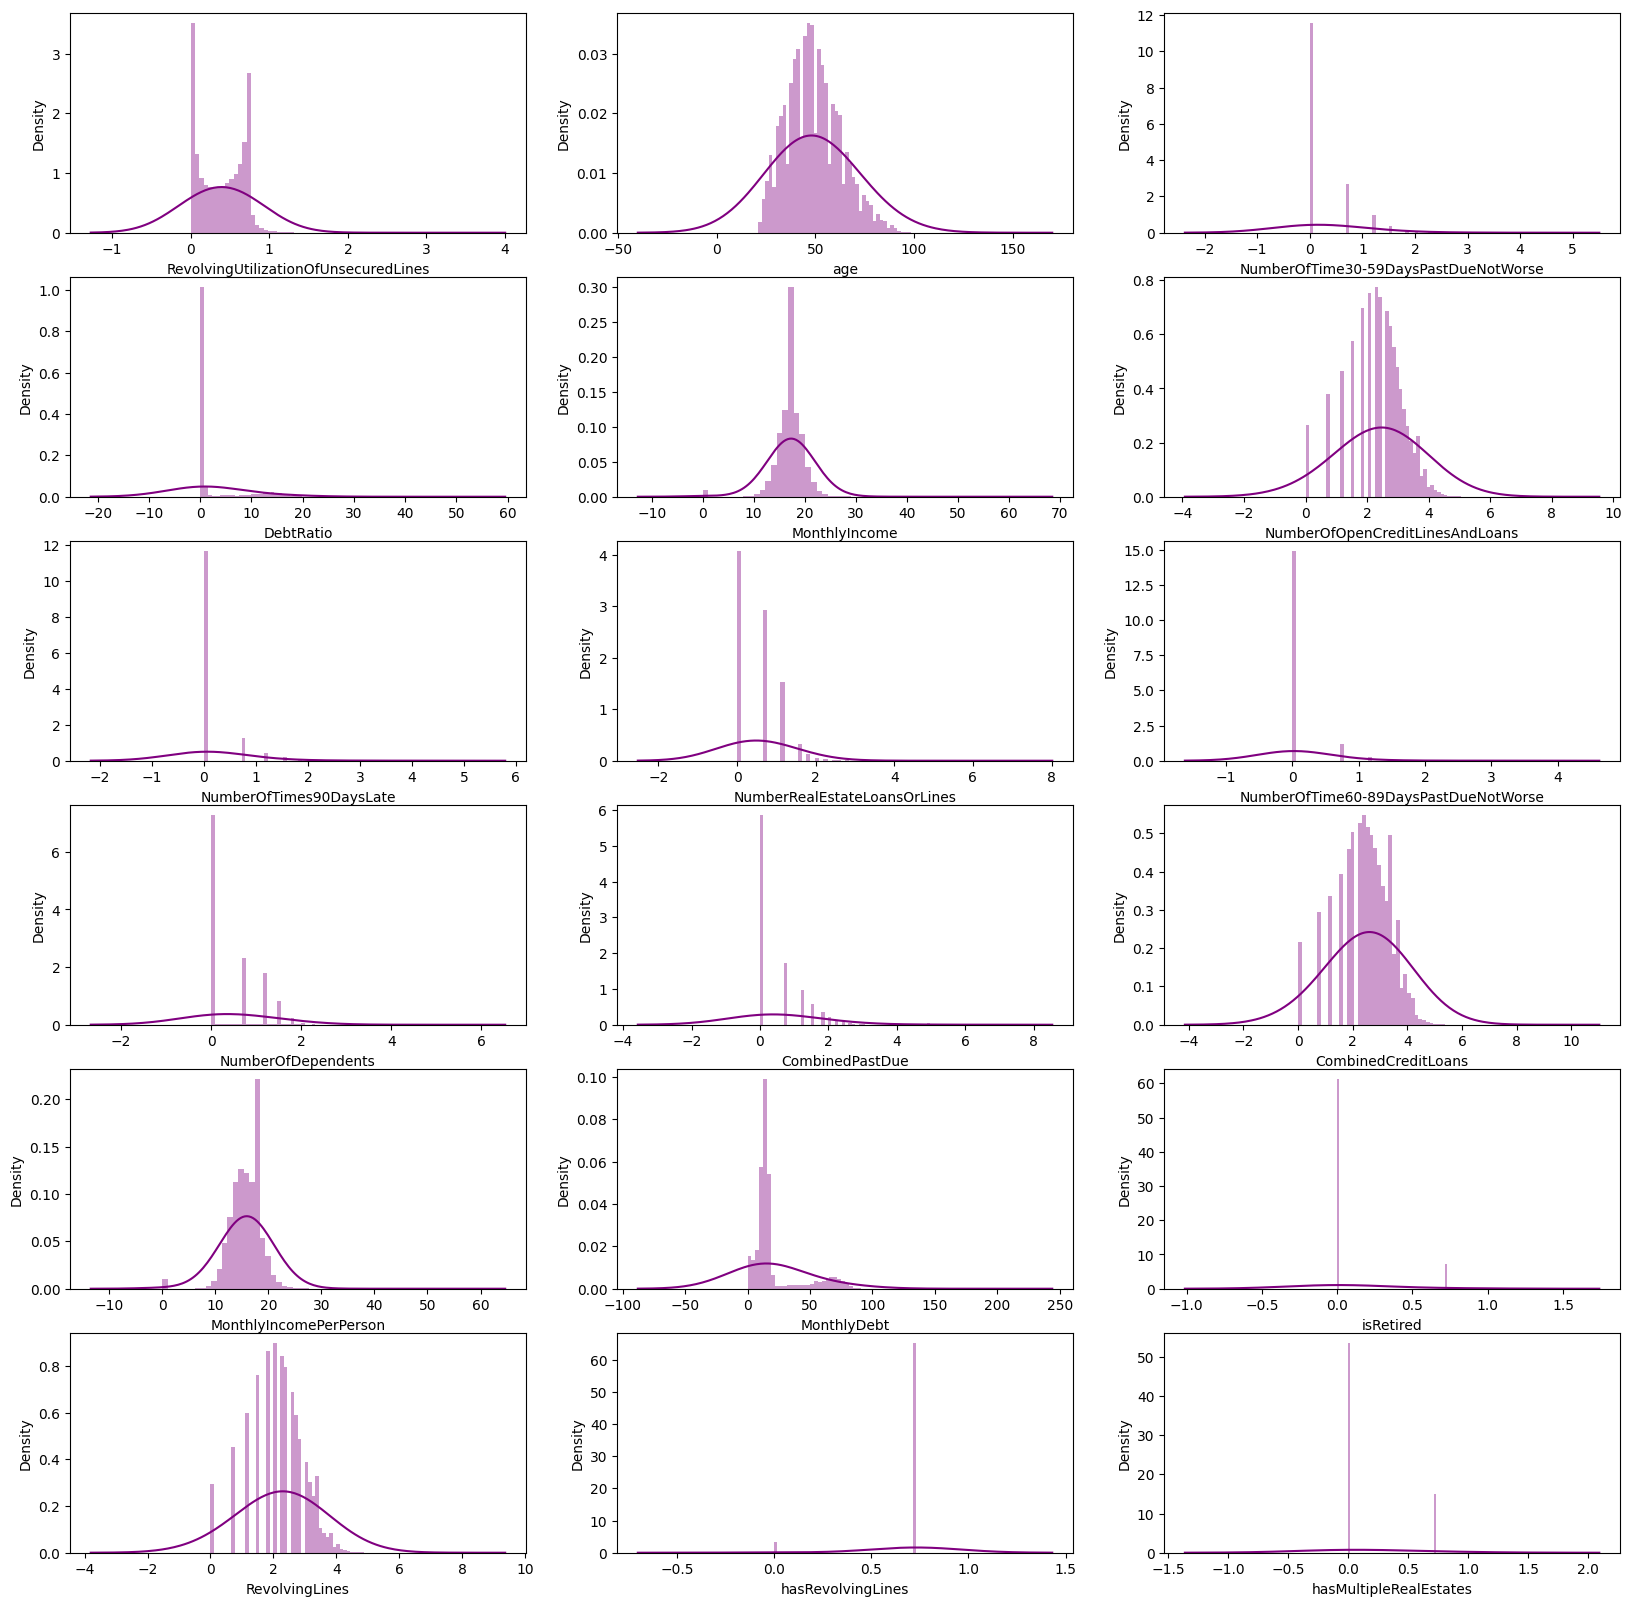

In [142]:
# Get column names for plotting
columnList = list(df_test_transformed.columns)

# Create a 6x3 subplot figure
fig = plt.figure(figsize=[20,20])

# Plot distribution plots for each column in the list
for col, i in zip(columnList, range(1, 19)):
    axes = fig.add_subplot(6, 3, i)
    sns.distplot(os_data_X_tranformed[col], ax=axes, kde_kws={'bw': 1.5}, color='purple')

# Show the figure
plt.show()


* Skewness is reduced and now the graphs are looking good

In [143]:
# Create a copy of the training data for transformation
df_train_transformed = df_train.copy()

# Calculate skewness measures for the columns in df_train
skewM = SkewMeasure(df_train)

# Apply Box-Cox transformation with lambda 0.15 to selected columns
for i in skewM.index:
    df_train_transformed[i] = special.boxcox1p(df_train_transformed[i], 0.15)


#### Standaradization

In [144]:
# Fit a StandardScaler to the training data
scaler = StandardScaler().fit(os_data_X)

# Transform the training and test data using the scaler
X_train_scaled = scaler.transform(os_data_X)
X_test_scaled = scaler.transform(df_test)


In [145]:
# Fit a StandardScaler to the upsampled and transformed training data
scaler = StandardScaler().fit(df_upsampled_transformed)

# Transform the upsampled training data and standardized test data using the scaler
X_train_scaled_upsampled = scaler.transform(df_upsampled_transformed)
X_test_scaled_upsampled = scaler.transform(df_test_standaradized)


In [146]:
# Fit a StandardScaler to the downsampled and transformed training data
scaler = StandardScaler().fit(df_downsampled_transformed)

# Transform the downsampled training data and standardized test data using the scaler
X_train_scaled_downsampled = scaler.transform(df_downsampled_transformed)
X_test_scaled_downsampled = scaler.transform(df_test_standaradized)


---

# Modeling

**Training the Model:**

- We will be training the model using different algorithms.
- We will also be comparing the results using a transformed dataset and the original dataset.
- We will check and compare which algorithms transformations work on and which do not.
- We will be performing Cross Validation and observing if the model's performance fluctuates, using statistical measures such as mean and standard deviation.

**Predicting Customer Data:**

- We will predict customers from the test dataset and compare the predictions with the true values from the test dataset using various evaluation metrics to determine the best-performing model.

**Model Evaluation:**

- We will evaluate our model using different metrics and discuss why some metrics might fail in our case study, which is one of the most popular ways to evaluate model performance.

**Common Evaluation Metrics:**

- **Precision:** How well the model predicts positive events.
  - Precision = True Positive / (True Positive + False Positives)

- **Recall:** How well the model captures relevant events (coverage).
  - Recall = True Positive / (True Positive + False Negatives)

- **F1 Score:** A harmonic mean between Precision and Recall, penalizing the lower-scoring metric to maintain a trade-off.

- **Area Under the Curve & ROC:** Measures how well a model can differentiate between classes.
  - It is plotted with False Positive Rate on the x-axis and True Positive Rate on the y-axis using different thresholds.
  - A higher area above the straight diagonal line indicates better model performance compared to random class predictions.

**Comparing Models:**

- We will compare the AUC results of different modeling techniques to identify the top-performing models.

**Hyperparameter Tuning:**

- We will tune the hyperparameters of the models to improve results and assess the impact of tuning on model performance.


---


## Neural Network

In [147]:
# Custom precision metric
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # Count true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # Count predicted positives
    precision = true_positives / (predicted_positives + K.epsilon()) # Calculate precision
    return precision

# Custom recall metric
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # Count true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # Count all possible positives
    recall = true_positives / (possible_positives + K.epsilon()) # Calculate recall
    return recall


In [178]:
def fit_model(data, labels, test_data, test_label, epochs, batch_size):
    # Define the number of input features
    n_inputs = data.shape[1]

    # Create a Sequential neural network model
    model = keras.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(n_inputs, )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid')

    # Specify the filename for saving the best model
    model_file_name = 'MLP_predict_default_case_study.hdf5'

    # Define checkpoints to save the best model based on validation precision
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')

    # Define early stopping based on validation recall
    early = EarlyStopping(monitor="val_recall", mode="max", patience=15)

    # Compile the model with Adam optimizer, binary cross-entropy loss, and custom metrics
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=[precision, recall])

    # Train the model and monitor validation performance
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       validation_data=(test_data, test_label))

    return model


In [179]:
def compute_precisions_thresolds(data, labels, test_data, test_label, epochs, batch_size):
    # Train the model on the provided data
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)

    # Predict labels on the test data
    y_test_pred = trained_model.predict(test_data)

    # Initialize lists and data frame to store metrics
    P_macro = []; P_micro = []
    R_macro = []; R_micro = []
    F1_macro = []; F1_micro = []
    cut_off = []
    metrics = pd.DataFrame()

    # Define a list of threshold values
    threshold_list = [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96]

    # Loop through the threshold values and calculate precision, recall, and F1 metrics
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el > thres else 0 for el in y_test_pred]
        
        # Calculate macro and micro-averaged precision
        prec_macro = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='macro'), 2)
        P_macro.append(prec_macro)
        prec_micro = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='micro'), 2)
        P_micro.append(prec_micro)
        
        # Calculate macro and micro-averaged recall
        rec_macro = round(recall_score(test_label, y_test_pred_new, pos_label=1, average='macro'), 2)
        R_macro.append(rec_macro)
        rec_micro = round(recall_score(test_label, y_test_pred_new, pos_label=1, average='micro'), 2)
        R_micro.append(rec_micro)
        
        # Calculate macro and micro-averaged F1 score
        f1_macro = round(f1_score(test_label, y_test_pred_new, average='macro'), 2)
        F1_macro.append(f1_macro)
        f1_micro = round(f1_score(test_label, y_test_pred_new, average='micro'), 2)
        F1_micro.append(f1_micro)

    # Create a data frame to store the calculated metrics
    metrics = pd.DataFrame({'Threshold': cut_off, 'Precision Macro': P_macro, 'Precision Micro': P_micro,
                            'Recall Macro': R_macro, 'Recall Micro': R_micro,
                            'F1 Score Macro': F1_macro, 'F1 Score Micro': F1_micro})

    # Sort the metrics data frame by the 'Threshold' column in descending order
    return metrics.sort_values(by=['Threshold'], ascending=False)


#### Appling Neural Network model on Box Cox transformed dataset

In [180]:
# Calculate precision, recall, and F1 metrics using the custom function
box_cox_metrics = compute_precisions_thresolds(os_data_X_tranformed, os_data_y, df_test_transformed, y_test, epochs=15, batch_size=128)


Epoch 1/15
1743/1743 [==============================] - 3s 1ms/step - loss: 0.6360 - precision: 0.6874 - recall: 0.6948 - val_loss: 0.4831 - val_precision: 0.1905 - val_recall: 0.7535
Epoch 2/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4773 - precision: 0.7582 - recall: 0.8165 - val_loss: 0.4498 - val_precision: 0.1841 - val_recall: 0.7576
Epoch 3/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4548 - precision: 0.7644 - recall: 0.8395 - val_loss: 0.3820 - val_precision: 0.2049 - val_recall: 0.6944
Epoch 4/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4412 - precision: 0.7701 - recall: 0.8397 - val_loss: 0.4526 - val_precision: 0.1817 - val_recall: 0.7564
Epoch 5/15
1743/1743 [==============================] - 3s 1ms/step - loss: 0.4335 - precision: 0.7719 - recall: 0.8418 - val_loss: 0.4521 - val_precision: 0.1790 - val_recall: 0.7601
Epoch 6/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.42

In [181]:
box_cox_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.68             0.93          0.50          0.93   
8       0.95             0.68             0.93          0.50          0.93   
7       0.90             0.70             0.93          0.52          0.93   
6       0.80             0.71             0.93          0.58          0.93   
5       0.70             0.66             0.91          0.69          0.91   
4       0.60             0.60             0.85          0.73          0.85   
3       0.50             0.58             0.77          0.75          0.77   
2       0.40             0.57             0.71          0.75          0.71   
1       0.30             0.56             0.64          0.74          0.64   
0       0.25             0.56             0.61          0.73          0.61   

   F1 Score Macro  F1 Score Micro  
9            0.49            0.93  
8            0.49            0.93  
7            0.52            0.93  
6            0.61            0.93  
5            0.67            0.91  
4            0.63            0.85  
3            0.58            0.77  
2            0.54            0.71  
1            0.50            0.64  
0            0.48            0.61

#### Applying Neural Network on Standardized dataset

In [152]:
# Calculate precision, recall, and F1 metrics using standardized data
standardized_metrics = compute_precisions_thresolds(X_train_scaled, os_data_y, X_test_scaled, y_test, epochs=15, batch_size=128)


Epoch 1/15
1743/1743 [==============================] - 3s 1ms/step - loss: 0.4834 - precision: 0.7597 - recall: 0.8138 - val_loss: 0.4533 - val_precision: 0.1779 - val_recall: 0.7549
Epoch 2/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.4055 - precision: 0.7992 - recall: 0.8434 - val_loss: 0.3646 - val_precision: 0.2176 - val_recall: 0.6870
Epoch 3/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.3519 - precision: 0.8333 - recall: 0.8326 - val_loss: 0.3397 - val_precision: 0.2381 - val_recall: 0.6448
Epoch 4/15
1743/1743 [==============================] - 2s 1ms/step - loss: 0.3382 - precision: 0.8426 - recall: 0.8320 - val_loss: 0.3625 - val_precision: 0.2142 - val_recall: 0.6729
Epoch 5/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3325 - precision: 0.8449 - recall: 0.8329 - val_loss: 0.3233 - val_precision: 0.2332 - val_recall: 0.6403
Epoch 6/15
1743/1743 [==============================] - 3s 1ms/step - loss: 0.32

In [153]:
standardized_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.97             0.93          0.50          0.93   
8       0.95             0.80             0.93          0.50          0.93   
7       0.90             0.72             0.93          0.50          0.93   
6       0.80             0.70             0.93          0.53          0.93   
5       0.70             0.67             0.92          0.63          0.92   
4       0.60             0.62             0.88          0.71          0.88   
3       0.50             0.60             0.83          0.74          0.83   
2       0.40             0.58             0.78          0.75          0.78   
1       0.30             0.57             0.73          0.75          0.73   
0       0.25             0.57             0.70          0.75          0.70   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.49            0.93  
6            0.55            0.93  
5            0.65            0.92  
4            0.65            0.88  
3            0.62            0.83  
2            0.59            0.78  
1            0.56            0.73  
0            0.54            0.70

#### Applying Neural Network on Original Standaradized dataset

In [154]:
# Fit a StandardScaler to the training data, then transform both training and test data
scaler = StandardScaler().fit(df_train)
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)


In [155]:
# Calculate precision, recall, and F1 metrics using standardized data
base_metrics = compute_precisions_thresolds(df_train_scaled, y_train, df_test_scaled, y_test, epochs=10, batch_size=128)


Epoch 1/10
934/934 [==============================] - 2s 1ms/step - loss: 0.2227 - precision: 0.2144 - recall: 0.0386 - val_loss: 0.1879 - val_precision: 0.1346 - val_recall: 0.0175
Epoch 2/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1910 - precision: 0.2417 - recall: 0.0390 - val_loss: 0.1857 - val_precision: 0.2963 - val_recall: 0.0479
Epoch 3/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1879 - precision: 0.2797 - recall: 0.0424 - val_loss: 0.1855 - val_precision: 0.1517 - val_recall: 0.0202
Epoch 4/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1871 - precision: 0.2891 - recall: 0.0455 - val_loss: 0.1849 - val_precision: 0.1496 - val_recall: 0.0205
Epoch 5/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1854 - precision: 0.2867 - recall: 0.0429 - val_loss: 0.1847 - val_precision: 0.1695 - val_recall: 0.0246
Epoch 6/10
934/934 [==============================] - 1s 1ms/step - loss: 0.1847 - precisi

In [156]:
base_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.47             0.93          0.50          0.93   
7       0.90             0.47             0.93          0.50          0.93   
6       0.80             0.47             0.93          0.50          0.93   
5       0.70             0.47             0.93          0.50          0.93   
4       0.60             0.47             0.93          0.50          0.93   
3       0.50             0.78             0.93          0.51          0.93   
2       0.40             0.72             0.93          0.62          0.93   
1       0.30             0.70             0.93          0.67          0.93   
0       0.25             0.68             0.92          0.69          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.48            0.93  
4            0.48            0.93  
3            0.51            0.93  
2            0.65            0.93  
1            0.68            0.93  
0            0.69            0.92

#### Applying Neural Network on Upsampled dataset

In [157]:
# Calculate precision, recall, and F1 metrics using upsampled and standardized data
upsampled_metrics = compute_precisions_thresolds(X_train_scaled_upsampled, y_train_upsampled, df_test_standaradized, y_test, epochs=10, batch_size=128)


Epoch 1/10
1653/1653 [==============================] - 3s 1ms/step - loss: 0.5062 - precision: 0.7623 - recall: 0.7287 - val_loss: 65054.4219 - val_precision: 0.0543 - val_recall: 0.1473
Epoch 2/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4759 - precision: 0.7806 - recall: 0.7479 - val_loss: 81353.2188 - val_precision: 0.0538 - val_recall: 0.1482
Epoch 3/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4705 - precision: 0.7826 - recall: 0.7518 - val_loss: 148815.6719 - val_precision: 0.0539 - val_recall: 0.1606
Epoch 4/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4686 - precision: 0.7820 - recall: 0.7566 - val_loss: 210555.3594 - val_precision: 0.0536 - val_recall: 0.1628
Epoch 5/10
1653/1653 [==============================] - 2s 1ms/step - loss: 0.4678 - precision: 0.7795 - recall: 0.7604 - val_loss: 185322.4219 - val_precision: 0.0540 - val_recall: 0.1642
Epoch 6/10
1653/1653 [==============================] - 2

In [158]:
upsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.49             0.75          0.49          0.75   
8       0.95             0.49             0.75          0.49          0.75   
7       0.90             0.49             0.75          0.49          0.75   
6       0.80             0.49             0.75          0.49          0.75   
5       0.70             0.49             0.75          0.49          0.75   
4       0.60             0.49             0.75          0.49          0.75   
3       0.50             0.49             0.74          0.48          0.74   
2       0.40             0.49             0.74          0.48          0.74   
1       0.30             0.49             0.74          0.48          0.74   
0       0.25             0.49             0.74          0.48          0.74   

   F1 Score Macro  F1 Score Micro  
9            0.47            0.75  
8            0.47            0.75  
7            0.47            0.75  
6            0.47            0.75  
5            0.47            0.75  
4            0.47            0.75  
3            0.47            0.74  
2            0.47            0.74  
1            0.47            0.74  
0            0.47            0.74

#### Applying Neural Network on Downsampled dataset

In [159]:
# Calculate precision, recall, and F1 metrics using downsampled and standardized data
downsampled_metrics = compute_precisions_thresolds(X_train_scaled_downsampled, y_train_downsampled, df_test_standaradized, y_test, epochs=10, batch_size=128)


Epoch 1/10
126/126 [==============================] - 1s 3ms/step - loss: 0.6484 - precision: 0.6347 - recall: 0.6148 - val_loss: 12478.3721 - val_precision: 0.0295 - val_recall: 0.0069
Epoch 2/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5454 - precision: 0.7512 - recall: 0.7163 - val_loss: 17696.5098 - val_precision: 0.0330 - val_recall: 0.0073
Epoch 3/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5244 - precision: 0.7668 - recall: 0.7348 - val_loss: 15781.9639 - val_precision: 0.0309 - val_recall: 0.0073
Epoch 4/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5108 - precision: 0.7775 - recall: 0.7442 - val_loss: 18116.3262 - val_precision: 0.0408 - val_recall: 0.0094
Epoch 5/10
126/126 [==============================] - 0s 2ms/step - loss: 0.5060 - precision: 0.7727 - recall: 0.7527 - val_loss: 15018.0479 - val_precision: 0.0562 - val_recall: 0.0147
Epoch 6/10
126/126 [==============================] - 0s 2ms/step - lo

In [160]:
downsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.48             0.92           0.5          0.92   
8       0.95             0.48             0.92           0.5          0.92   
7       0.90             0.48             0.92           0.5          0.92   
6       0.80             0.48             0.92           0.5          0.92   
5       0.70             0.49             0.92           0.5          0.92   
4       0.60             0.48             0.92           0.5          0.92   
3       0.50             0.48             0.92           0.5          0.92   
2       0.40             0.48             0.92           0.5          0.92   
1       0.30             0.49             0.92           0.5          0.92   
0       0.25             0.48             0.92           0.5          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.92  
8            0.48            0.92  
7            0.48            0.92  
6            0.48            0.92  
5            0.49            0.92  
4            0.49            0.92  
3            0.48            0.92  
2            0.48            0.92  
1            0.49            0.92  
0            0.49            0.92


- It can be clearly seen that Deep learning models require scaling of the features so that errors can be minimized when features are nearly of the same scale. This enables backpropagation of errors, resulting in better optimization.

- No effect on Neural Network Models whether samples are downsampled or upsampled, but that is not the case when synthetic sampling is used.

- Results are more or less the same using Box Cox transformations and Standardization.

---

#### Training the model and predicting on unseen dataset:

- In total, 4 modeling techniques are used:
  - **Logistic Regression**
  - **Random Forest**
  - **XGBoost**
  - **Light GBM**

- Metrics will be calculated using each modeling technique.

- Confusion Matrix numbers are TN, FP, FN, TP.

- A joint plot of ROC AUC will be created to assess the performance of the classifiers.

### Various ML models

In [161]:
# Calculate and return various classification metrics and the confusion matrix
def cal_score(y_test, y_pred): 
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate macro and micro-averaged precision, recall, and F1 score
    prec_scr_macro = precision_score(y_test, y_pred, average='macro') * 100
    prec_scr_micro = precision_score(y_test, y_pred, average='micro') * 100
    rec_scr_macro = recall_score(y_test, y_pred, average='macro') * 100
    rec_scr_micro = recall_score(y_test, y_pred, average='micro') * 100
    f1_scr_macro = f1_score(y_test, y_pred, average='macro') * 100
    f1_scr_micro = f1_score(y_test, y_pred, average='micro') * 100
    
    # Return the calculated metrics and the confusion matrix
    return prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm


In [162]:
# Calculate and return various classification metrics for a given classifier
def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision Macro', 'Precision Micro', 'Recall Macro',
            'Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']

    # Calculate mean and standard deviation of accuracy via cross-validation
    crs_val = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val), 3)
    std_acc = round(np.std(crs_val), 3)

    # Fit the classifier and make predictions on the testing data
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)

    # Calculate precision, recall, F1 scores, and confusion matrix
    prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm = cal_score(testing_label, predictions)
    
    # Store the calculated metrics and confusion matrix
    result.extend([mean_acc, std_acc, prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)

    return series_result


In [163]:
# Dictionary containing various classifiers with associated instances
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Light GBM': LGBMClassifier(random_state=42)
}


#### Logistic Regression:

- The logistic function is defined as: $ 1/(1+e^-value) $

- Probability calculation for logistic regression: $  p(x) = e^(b0+b1*X)/(1+e^(b0+b1*X)) $

- The logistic regression formula for the log-odds is: $ ln(p(X)/1-p(X)) = b0+b1*X $

---


#### Evolution of Tree-Based Algorithms and Moving Towards XGBoost:

**Decision Tree:**
- A graphical representation of possible solutions to a decision based on certain conditions.

**Bagging:**
- Bootstrap aggregating or Bagging is an ensemble meta-algorithm that combines predictions from multiple decision trees through a majority voting mechanism.

**Random Forest:**
- A Bagging-based algorithm where only a subset of features is selected at random to build a forest or a collection of decision trees.

**Boosting:**
- Models are built sequentially by minimizing the errors from previous models while increasing (boosting) the influence of high-performing models.

**Gradient Boosting:**
- It employs the gradient descent algorithm to minimize errors in sequential models.

**XGBoost:**
- An optimized Gradient Boosting algorithm that utilizes parallel processing, tree-pruning, handling missing values, and regularization to avoid overfitting and bias.


---



#### Training Box Cox transformed dataset using ML algorithms

In [164]:
# Initialize an empty dictionary to store classifier results
frame = {}

# Loop through classifiers and calculate metrics, storing the results in the dictionary
for key in clf_dict:
    classifier_result = metrics_calculation(clf_dict[key], os_data_X_tranformed, df_test_transformed, os_data_y, y_test)
    frame[key] = classifier_result

# Create a DataFrame from the results
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df


Random Forest  \
Mean Accuracy                              0.934   
Accuracy deviation                         0.019   
Precision Macro                        62.581275   
Precision Micro                        89.233954   
Recall Macro                           68.054447   
Recall Micro                           89.233954   
F1 Score Macro                         64.604409   
F1 Score Micro                         89.233954   
Confusion Matrix    [[25851, 2098], [1126, 871]]   

                                         XGBoost  \
Mean Accuracy                              0.883   
Accuracy deviation                         0.024   
Precision Macro                        60.364816   
Precision Micro                        85.781073   
Recall Macro                           70.900863   
Recall Micro                           85.781073   
F1 Score Macro                         62.774821   
F1 Score Micro                         85.781073   
Confusion Matrix    [[24615, 3334], [924, 1073]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.799                         0.857  
Accuracy deviation                         0.007                         0.017  
Precision Macro                         58.29373                     59.772031  
Precision Micro                        78.588125                     83.059507  
Recall Macro                           74.300973                     73.883329  
Recall Micro                           78.588125                     83.059507  
F1 Score Macro                         58.761635                     61.778652  
F1 Score Micro                         78.588125                     83.059507  
Confusion Matrix    [[22149, 5800], [612, 1385]]  [[23609, 4340], [733, 1264]]

#### Training Standaradized dataset using ML algorithms

In [165]:
# Initialize an empty dictionary to store classifier results for standardized data
frame_std = {}

# Loop through classifiers and calculate metrics using standardized data, storing the results in the dictionary
for key in clf_dict:
    classifier_result_std = metrics_calculation(clf_dict[key], X_train_scaled, X_test_scaled, os_data_y, y_test)
    frame_std[key] = classifier_result_std

# Create a DataFrame from the results for standardized data
standardized_smote_df = pd.DataFrame(frame_std)
standardized_smote_df


Random Forest  \
Mean Accuracy                              0.934   
Accuracy deviation                         0.019   
Precision Macro                        62.541002   
Precision Micro                        89.183864   
Recall Macro                           68.120606   
Recall Micro                           89.183864   
F1 Score Macro                         64.588837   
F1 Score Micro                         89.183864   
Confusion Matrix    [[25832, 2117], [1122, 875]]   

                                         XGBoost  \
Mean Accuracy                              0.883   
Accuracy deviation                         0.024   
Precision Macro                        60.174138   
Precision Micro                        85.497228   
Recall Macro                           70.888292   
Recall Micro                           85.497228   
F1 Score Macro                         62.530282   
F1 Score Micro                         85.497228   
Confusion Matrix    [[24524, 3425], [918, 1079]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                               0.83                         0.857  
Accuracy deviation                         0.018                         0.018  
Precision Macro                        59.538227                     59.763526  
Precision Micro                        84.388566                     83.012756  
Recall Macro                           70.945313                      73.92803  
Recall Micro                           84.388566                     83.012756  
F1 Score Macro                         61.658968                     61.759128  
F1 Score Micro                         84.388566                     83.012756  
Confusion Matrix    [[24164, 3785], [890, 1107]]  [[23592, 4357], [730, 1267]]

#### Training Original dataset with using hyperparameter which is balancing minority class as per the majority class

In [166]:
# Dictionary containing various classifiers with balanced class weights
clf_dict_balanced = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10}),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=10),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight={0: 1, 1: 10}),
    'Light GBM': LGBMClassifier(random_state=42, scale_pos_weight=10)
}


In [167]:
# Initialize an empty dictionary to store classifier results with balanced class weights
frame_balanced = {}

# Loop through classifiers with balanced class weights and calculate metrics, storing the results in the dictionary
for key in clf_dict_balanced:
    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key] = classifier_result_balanced

# Create a DataFrame from the results with balanced class weights
balanced_df = pd.DataFrame(frame_balanced)
balanced_df


Random Forest                       XGBoost  \
Mean Accuracy                             0.935                         0.866   
Accuracy deviation                          0.0                         0.001   
Precision Macro                       74.282694                     61.604048   
Precision Micro                       93.488279                     85.928004   
Recall Macro                          56.895917                     74.536611   
Recall Micro                          93.488279                     85.928004   
F1 Score Macro                        59.853718                     64.433248   
F1 Score Micro                        93.488279                     85.928004   
Confusion Matrix    [[27703, 246], [1704, 293]]  [[24506, 3443], [771, 1226]]   

                           Logistic Regression                     Light GBM  
Mean Accuracy                            0.929                         0.851  
Accuracy deviation                       0.002                         0.002  
Precision Macro                      48.350661                     61.426655  
Precision Micro                      92.326187                     84.715822  
Recall Macro                         49.717254                     76.607298  
Recall Micro                         92.326187                     84.715822  
F1 Score Macro                       48.478376                     64.142619  
F1 Score Micro                       92.326187                     84.715822  
Confusion Matrix    [[27637, 312], [1986, 11]]  [[24026, 3923], [654, 1343]]

- XGBoost and Light GBM are performing better in terms of Recall & Light GBM whereas Random Forest in Precision

#### Training Scaled oiginal dataset with using hyperparameter which is balancing minority class as per the majority class

In [168]:
# Initialize an empty dictionary to store classifier results with balanced class weights and standardized data
frame_balanced_scaled = {}

# Loop through classifiers with balanced class weights and calculate metrics using standardized data, storing the results in the dictionary
for key in clf_dict_balanced:
    classifier_result_balanced_scaled = metrics_calculation(clf_dict_balanced[key], df_train_transformed, df_test_transformed, y_train, y_test)
    frame_balanced_scaled[key] = classifier_result_balanced_scaled

# Create a DataFrame from the results with balanced class weights and standardized data
balanced_df_scaled = pd.DataFrame(frame_balanced_scaled)
balanced_df_scaled


Random Forest                       XGBoost  \
Mean Accuracy                             0.935                         0.866   
Accuracy deviation                          0.0                         0.001   
Precision Macro                       74.123954                     61.601176   
Precision Micro                       93.474922                     85.924664   
Recall Macro                          56.726021                     74.534822   
Recall Micro                          93.474922                     85.924664   
F1 Score Macro                        59.619149                     64.429475   
F1 Score Micro                        93.474922                     85.924664   
Confusion Matrix    [[27706, 243], [1711, 286]]  [[24505, 3444], [771, 1226]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.855                         0.851  
Accuracy deviation                         0.002                         0.002  
Precision Macro                        61.136065                     61.426655  
Precision Micro                        85.119882                     84.715822  
Recall Macro                            74.75464                     76.607298  
Recall Micro                           85.119882                     84.715822  
F1 Score Macro                           63.7974                     64.142619  
F1 Score Micro                         85.119882                     84.715822  
Confusion Matrix    [[24236, 3713], [743, 1254]]  [[24026, 3923], [654, 1343]]

- Logistic Regression metrics are changed while all other model metrics remain same
- Hence, Logistic Regression algorithm requires scaling of features whereas tree based doesn't.

#### Plotting ROC AUC for the ML models for the transformed dataset

In [169]:
# List of models, each with a label and associated classifier instance
models = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=42)
    },
    {
    'label': 'XGBoost',
    'model': XGBClassifier(random_state=42)
    },
    {
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state=42)
    },
    {
    'label': 'Light GBM',
    'model': LGBMClassifier(random_state=42)
    }
]


In [170]:
# Plot ROC curves for multiple models and display the Receiver Operating Characteristic
def plot_multiplt_rocauc(models, train_X, train_y, dev_X, dev_y):
    # Iterate through the provided models
    for m in models:
        model = m['model']
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve for the current model
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    
    # Customize the ROC curve plot
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()  # Display the ROC curves
    
    return


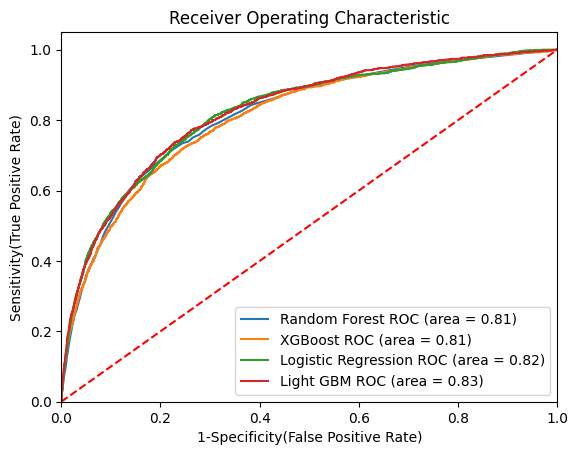

In [171]:
# Plot ROC curves for the models
plot_multiplt_rocauc(models, os_data_X_tranformed, os_data_y, df_test_transformed, y_test)


- AUC of all the models are on a similar scale except the XGBoost model which is 0.1 on a higher side
- AUC of XGBoost Light GBM are performing beyeer than the others

**Key Takeaways:**

- Tree-Based models don't require scaling of the features.
- Logistic Regression, a statistical model, requires feature scaling.
- Upsampling of the minority class, downsampling of the majority class, and SMOTE sampling results are not better compared to hyperparameter tuning using class weights in the model itself.

**Our Approach:**

- We will proceed with the original dataset without scaling the features but will use class weights in the model itself.

---

#### Feature Importance

    - We will be plotting top features by importance of all the ML algorithms.
    - we will be plotting Logistic Regression features by correlation.

In [172]:
# Plot feature importances for a given model
def plot_feature_importances(model, data):
    # Create a horizontal bar chart to display feature importances
    plt.figure(figsize=(8, 6))
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    
    # Set y-axis labels to feature names
    plt.yticks(np.arange(n_features), data.columns)
    
    # Set labels for the x and y axes
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


Model is  Random Forest
Model is  XGBoost
Model is  Light GBM


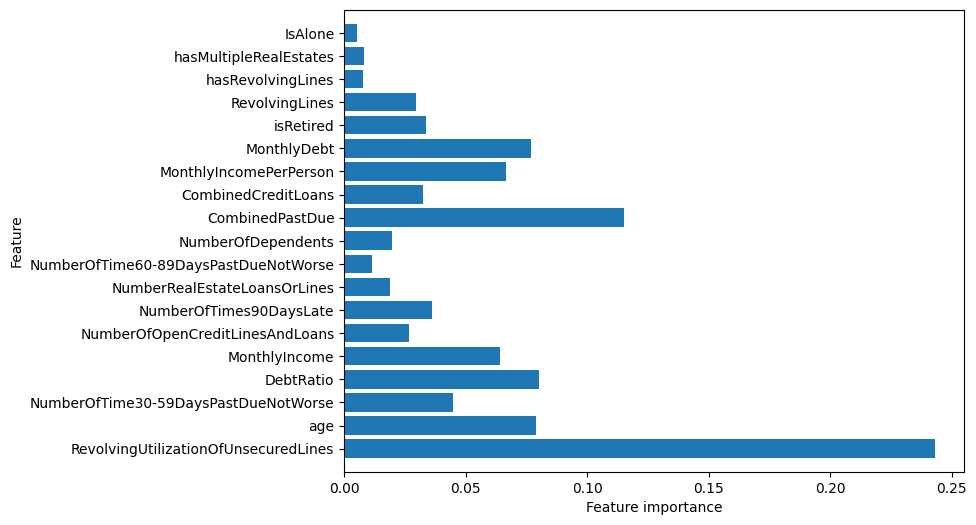

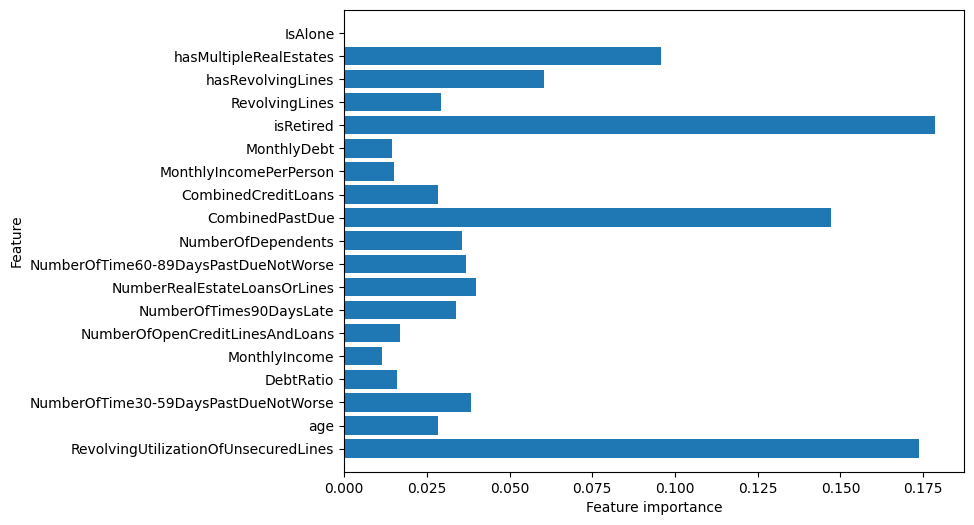

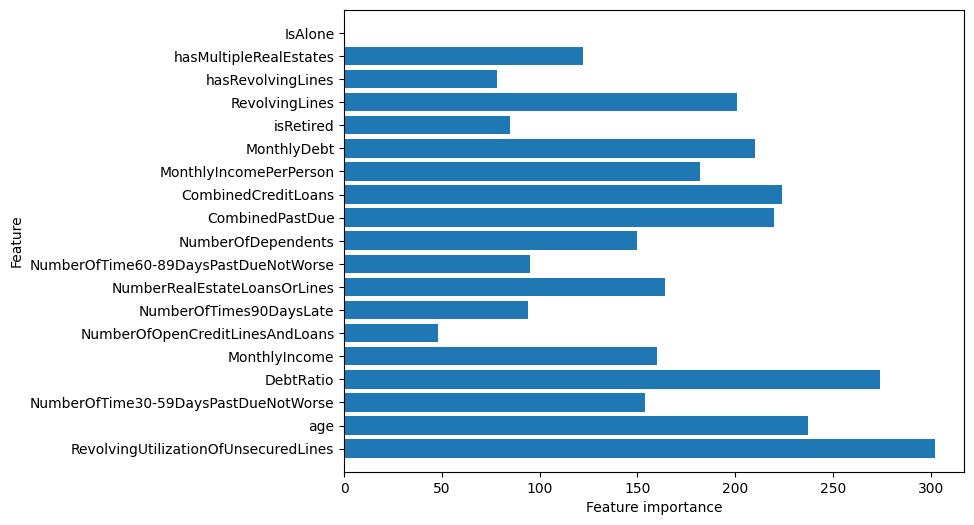

In [174]:
# Iterate through classifiers and plot feature importances for all except 'Logistic Regression'
for key in clf_dict.keys():
    if key == 'Logistic Regression':
        continue
    else:
        print('Model is', key)
        plot_feature_importances(clf_dict[key], os_data_X_tranformed)


- In all ML models, ratio of amount owed to the credit limit is the top feature followed by Combined Past Due which is the summation of all dues by a borrower
- In Light GBM model, others features are also contributing to a greater extent

In [175]:
# Fit a Logistic Regression model to the transformed data
logreg = LogisticRegression(random_state=42)
logreg.fit(os_data_X_tranformed, os_data_y)

# Create a DataFrame to store feature names and their correlations
coeff_df = pd.DataFrame(os_data_X_tranformed.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

# Sort the DataFrame by feature correlation in descending order
coeff_df.sort_values(by='Correlation', ascending=False)


Feature  Correlation
0   RevolvingUtilizationOfUnsecuredLines     4.182207
10                       CombinedPastDue     3.012628
11                   CombinedCreditLoans     1.336073
12                MonthlyIncomePerPerson     0.426284
5        NumberOfOpenCreditLinesAndLoans     0.275871
9                     NumberOfDependents     0.248588
13                           MonthlyDebt     0.003340
1                                    age    -0.009563
3                              DebtRatio    -0.019295
7           NumberRealEstateLoansOrLines    -0.232685
4                          MonthlyIncome    -0.451200
17                hasMultipleRealEstates    -0.841009
6                NumberOfTimes90DaysLate    -1.002851
15                        RevolvingLines    -1.093194
18                               IsAlone    -1.188076
8   NumberOfTime60-89DaysPastDueNotWorse    -1.489846
2   NumberOfTime30-59DaysPastDueNotWorse    -1.667136
16                     hasRevolvingLines    -1.806813
14                             isRetired    -2.523409

* Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability)

---

#### Feature Selection using RFECV

- We will be using RFECV on * **Random Forest** to remove correlated features because they might be providing the same information

In [176]:
# Perform Recursive Feature Elimination (RFE) with Cross-Validation
def RFE(model, training_data, training_label):
    rfc = model
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv.fit(training_data, training_label)

    # Print the optimal number of features selected
    print('Optimal number of features: {}'.format(rfecv.n_features_))

    # Create a new training dataset with selected features
    training_data_rfe = training_data.drop(training_data.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    
    # Plot the progress of feature elimination
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    
    # Create a DataFrame to store feature importance
    dset = pd.DataFrame()
    dset['attr'] = training_data.columns
    dset['importance'] = rfecv.estimator_.feature_importances_

    # Sort the DataFrame by feature importance
    dset = dset.sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(16, 14))
    plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    plt.show()
    
    return training_data_rfe.columns.tolist()


In [ ]:
# Perform RFE with Cross-Validation using a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv.fit(os_data_X_tranformed, os_data_y)

# Print the optimal number of features selected
print('Optimal number of features: {}'.format(rfecv.n_features_))


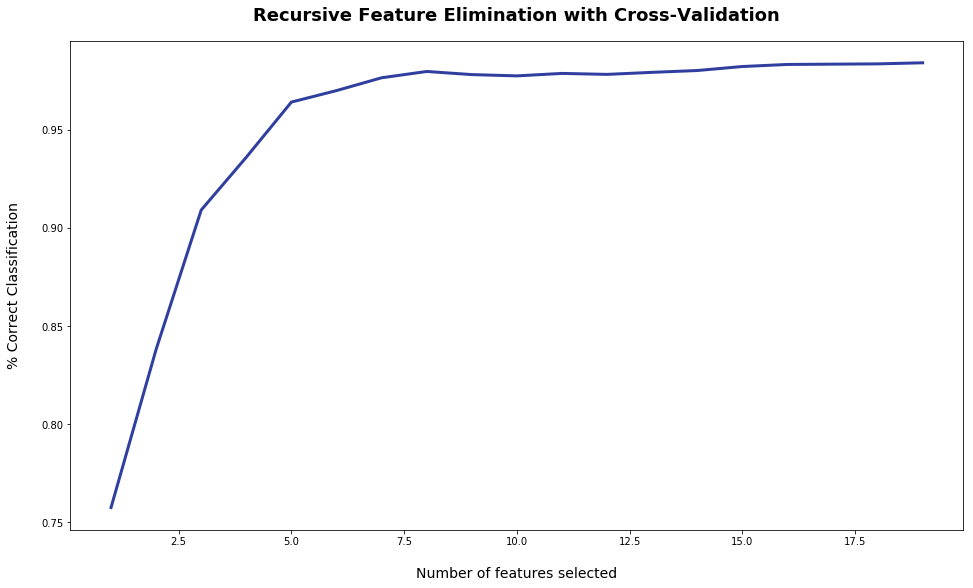

In [ ]:
# Plot the progress of Recursive Feature Elimination with Cross-Validation
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()


In [ ]:
# Identify the indices of non-supported features (features to be eliminated)
print(np.where(rfecv.support_ == False)[0])

# Create a new dataset with selected features based on RFE
os_data_X_tranformed_rfe = os_data_X_tranformed.drop(os_data_X_tranformed.columns[np.where(rfecv.support_ == False)[0]], axis=1)
os_data_X_tranformed_rfe.columns


[]


Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

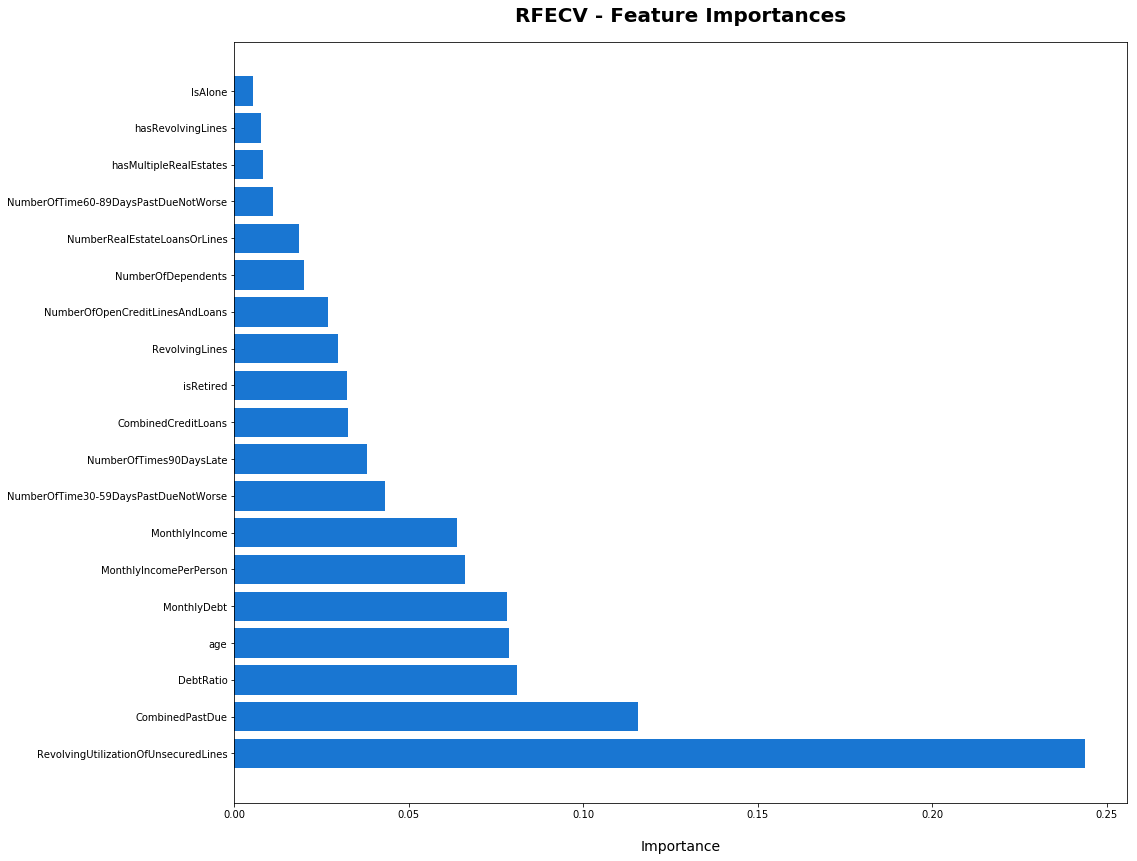

In [ ]:
# Create a DataFrame to store feature names and their importances
dset = pd.DataFrame()
dset['attr'] = os_data_X_tranformed.columns
dset['importance'] = rfecv.estimator_.feature_importances_

# Sort the DataFrame by feature importance
dset = dset.sort values(by='importance', ascending=False)

# Plot feature importances using a horizontal bar chart
plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()


* Since our optimal performance is with the complete features and no feature is eliminated, we wil be proceeding with the complete Feature Engineered inputs.

---


### Hypter Paramter Tuning for the Random Forest, XGBoost, and LightGBM
- We will be using GridSearchCV for hyperparamater tuning
- Now we will be using Metrics such as Precision, Recall, F1 Score on class 1 only
- Previously * **macro** and * **micro** were used to give idea how these 2 separate metrics are calculated

In [ ]:
# Perform hyperparameter tuning for a given classifier using GridSearchCV
def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):
    result = []
    cols = ['Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
    
    model_name = {}
    class_str = str(classifier)
    
    # Hyperparameter tuning for Random Forest
    if 'Random' in class_str:
        param_grid = {
            "n_estimators": [27, 36, 100, 200],
            "max_depth": [5, 7, 9, 15],
            "min_samples_leaf": [2, 4, 6, 8]
        }
        model = GridSearchCV(classifier, param_grid=param_grid, cv=StratifiedKFold(5))
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)

    # Hyperparameter tuning for XGBoost
    elif 'XG' in class_str:
        parameters = {
            'n_estimators': [100, 200], 
            'max_depth': [3, 5, 8], 
            'gamma': [0.25, 0.5, 1],
            'reg_alpha': [0.1, 0.25, 0.5],
            'reg_lambda': [0.5, 1, 1.15],
            'scale_pos_weight': [8, 10, 12, 15]
        }
        model = GridSearchCV(classifier, parameters, scoring="neg_log_loss", cv=StratifiedKFold(5), n_jobs=-1, verbose=2)
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    # Hyperparameter tuning for LightGBM
    else:
        param_grid = {
            'n_estimators': [100, 250, 400],
            'min_split_gain': [0.25, 0.45, 0.7],
            'max_depth': [4, 7, 10],
            'subsample': [0.65, 0.85],
            'colsample_bytree': [0.45, 0.65, 0.85],
            'reg_lambda': [0.5, 1, 3, 5],
            'num_leaves': [30, 50, 70],
            'min_data_in_leaf': [100, 400, 600]
        }
        model = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(5), n_jobs=-1, verbose=2)
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    # Calculate precision, recall, F1 score, and confusion matrix
    prec_scr, rec_scr, f1_scr, cm = cal_score(test_label, y_pred)
    result.extend([prec_scr, rec_scr, f1_scr, cm])
    series_result = pd.Series(data=result, index=cols)   
    
    return series_result, model_name


In [ ]:
# Perform hyperparameter tuning for classifiers and collect the results
frame_hyperparamater = {}  # Store hyperparameter tuning results
model_params = []  # Store model parameters

for key in clf_dict:
    print(key)
    if key == 'Logistic Regression':
        continue

    # Perform hyperparameter tuning and obtain the results and best model parameters
    hyperparamater_result, model_parameters = hyperparameter_tuning(clf_dict[key], df_train, df_test, y_train, y_test)
    
    # Store hyperparameter tuning results in a dictionary
    frame_hyperparamater[key] = hyperparamater_result
    
    # Store best model parameters in a list
    model_params.append(model_parameters)

# Create a DataFrame to store hyperparameter tuning results
tuned_df = pd.DataFrame(frame_hyperparamater)


Random Forest
XGBoost
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Logistic Regression
Light GBM
Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


In [ ]:
model_params

[{'RandomForestClassifier(random_state=42)': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200,
                         random_state=42)},
 {'XGBClassifier(random_state=42)': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42,
                reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=8)},
 {'LGBMClassifier(random_state=42)': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
                 min_split_gain=0.25, num_leaves=70, random_state=42,
                 reg_lambda=5, subsample=0.65)}]

In [ ]:
# Dictionary of classifiers with balanced class weights and tuned hyperparameters
clf_dict_balanced = {
    'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1, 1:10}),
    'XGBoost': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight={0:1, 1:10}),
    'Light GBM': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)
}


In [ ]:
# Evaluate classifiers with balanced class weights and collect the results
frame_balanced = {}  # Store evaluation results

for key in clf_dict_balanced:
    # Evaluate the classifier with balanced class weights
    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    
    # Store the evaluation results in a dictionary
    frame_balanced[key] = classifier_result_balanced

# Create a DataFrame to store the evaluation results for classifiers with balanced class weights
balanced_df = pd.DataFrame(frame_balanced)


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Random Forest  \
Mean Accuracy                                0.9   
Accuracy deviation                         0.001   
Precision                                33.3127   
Recall                                   53.9309   
F1 Score                                 41.1855   
Confusion Matrix    [[25793, 2156], [920, 1077]]   

                                         XGBoost         Logistic Regression  \
Mean Accuracy                              0.881                       0.929   
Accuracy deviation                         0.001                       0.002   
Precision                                     29                     3.40557   
Recall                                   58.0871                    0.550826   
F1 Score                                  38.686                    0.948276   
Confusion Matrix    [[25109, 2840], [837, 1160]]  [[27637, 312], [1986, 11]]   

                                       Light GBM  
Mean Accuracy                              0.845  
Accuracy deviation                         0.002  
Precision                                25.4341  
Recall                                   68.9534  
F1 Score                                  37.161  
Confusion Matrix    [[23912, 4037], [620, 1377]]

#### Plotting ROC AUC for the ML models for the original dataset

In [ ]:
# List of classifiers with balanced class weights and tuned hyperparameters
models_balanced = [
    {
        'label': 'Random Forest',
        'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1, 1:10})
    },
    {
        'label': 'XGBoost',
        'model': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10)
    },
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(random_state=42, class_weight={0:1, 1:10})
    },
    {
        'label': 'Light GBM',
        'model': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)
    }
]


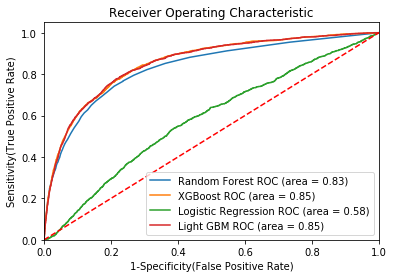

In [ ]:
plot_multiplt_rocauc(models,df_train,y_train, df_test, y_test)

* We will be going with the * **Light GBM** model as it is performing better than the other models

In [ ]:
# Create and fit a Light GBM model with tuned hyperparameters
model_lgb = LGBMClassifier(
    colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25,
    num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10
)

model_lgb.fit(df_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
               min_split_gain=0.25, num_leaves=70, random_state=42,
               reg_lambda=5, scale_pos_weight=10, subsample=0.65)

In [ ]:
# Make predictions using the Light GBM model and add them to a DataFrame
y_pred = model_lgb.predict(df_test)
df_test['predictions'] = y_pred


In [ ]:
# Lambda function for predicting probabilities using the Light GBM model
predict_model_lgb = lambda x: model_lgb.predict_proba(x).astype(float)


---

## Feature Importance and Model Explaination using SHAP and LIME

**Why Interpretability in Machine Learning Models is Needed:**

- **Fairness:** Understanding the trends of features with respect to the target variable is crucial for assessing model fairness.

- **Checking Causality of Features & Debugging Models:** Exploring what patterns among the features the model is capturing is essential for identifying issues and improving model performance.

- **Regulations:** Regulatory bodies may require explanations for decisions made by the model, especially in critical applications.

- **Explaining Model Performance using SHAP:** This helps transform black-box models into transparent ones.

**Our Approach:**

- We will examine model transparency using SHAP at the global level and LIME at the local level.

- The collective SHAP values can reveal how much each predictor contributes, either positively or negatively, to the target variable. This provides insights similar to variable importance plots but with the ability to show the specific positive or negative relationships of each variable with the target.

---


### SHAP(SHapely Additive exPlainations)

#### Variable Importance Plot — Global Interpretability

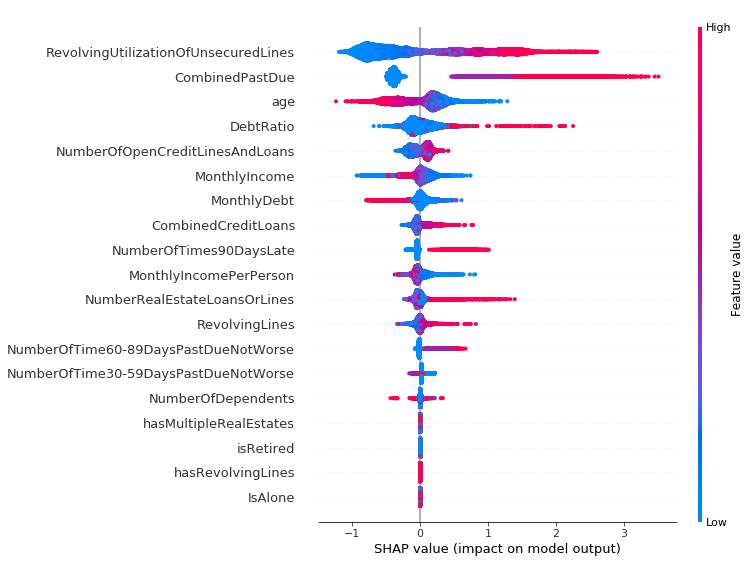

In [ ]:
X_importance = df_test

# Explain model predictions using SHAP library:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

# Plot a summary plot to visualize feature importance
shap.summary_plot(shap_values[1], X_importance)


- **Feature Importance:** Variables are ranked in descending order.

- **Impact:** The horizontal location indicates whether the effect of that value is associated with a higher or lower prediction.

- **Original Value:** The color represents whether that variable is high (in red) or low (in blue) for that observation.

- **Correlation:** A high level of the "RevolvingUtilizationOfUnsecuredLines" and "Debt Ratio" has a significant and positive impact on defaulting. The "high" aspect is depicted by the red color, and the "positive" impact is shown on the X-axis. On the other hand, "age" is equally correlated with the target variable and non-target variable, which may not provide much predictive power. The "Monthly Income" has a comparatively low effect on predicting values, and the effect is also low.

---

#### SHAP Dependence Plot — Global Interpretability

* The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 

* The function automatically includes another variable that your chosen variable interacts most with.

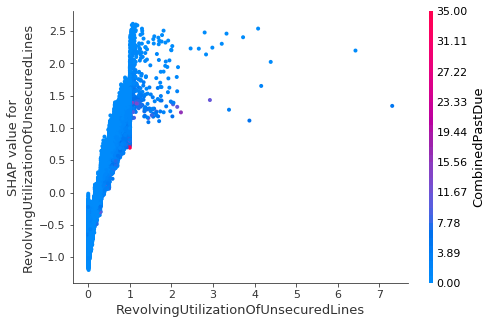

In [ ]:
# Create a SHAP dependence plot for the "RevolvingUtilizationOfUnsecuredLines" feature
shap.dependence_plot("RevolvingUtilizationOfUnsecuredLines", shap_values[1], X_importance)


* The following plot shows there is an very little linear and a bit of positive trend between “RevolvingUtilizationOfUnsecuredLines” and the target variable, and “RevolvingUtilizationOfUnsecuredLines” does not interact with “CombinedPastDue”.

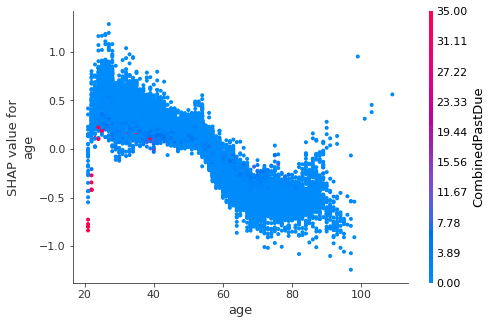

In [ ]:
# Create a SHAP dependence plot for the "age" feature
shap.dependence_plot("age", shap_values[1], X_importance)


* The following plot shows there is an good linear and a negative trend between “age” and the target variable, and “age” interacts with “CombinedPastDue” not so much.

---

#### LIME(Local Interpretable Model agnostic Explanations)

- If we want to understand how a single prediction was made for a given observation. This is where we use the LIME technique which stands for local interpretable model agnostic explanations.

#### Generating explainations using LIME

In [ ]:
# Create an explainer function for LimeTabularExplainer
explainer = LimeTabularExplainer(df_test.values, mode="classification", feature_names=df_test.columns)


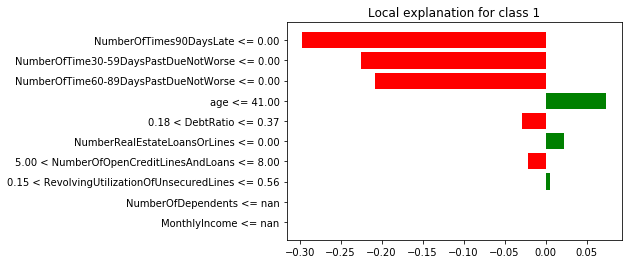

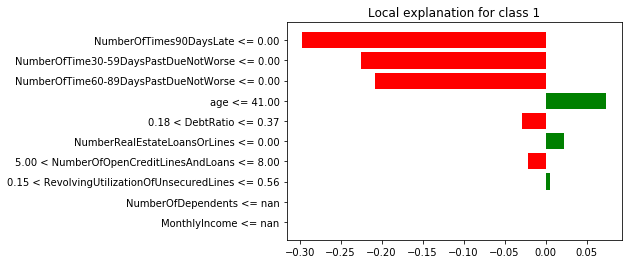

In [ ]:
# Explain a specific instance using LimeTabularExplainer and generate a pyplot figure
exp = explainer.explain_instance(df_test.iloc[3], predict_model_lgb, num_features=10)
exp.as_pyplot_figure()


* Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
* No of times 30-59, 59-90 days and 90 days past due having no values means not missed any due date showing veryr high negative correlation with the target
* age having less values lower than 41 relatively show positive corrrelation with the target

In [ ]:
# Store a new observation
i = 37
X_observation = df_test.iloc[[i], :]

# Explain the new observation using LimeTabularExplainer with a Light GBM model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)

# Display the explanation in a Jupyter notebook, showing the table and a limited number of features
explanation.show_in_notebook(show_table=True, show_all=False)

# Print the explanation score
print(explanation.score)


0.5596994738719498


* Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on defaulting for this row.

In [ ]:
# Store a new observation
i = 25
X_observation = df_test.iloc[[i], :]

# Explain the new observation using LimeTabularExplainer with a Light GBM model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)

# Display the explanation in a Jupyter notebook, showing the table and a limited number of features
explanation.show_in_notebook(show_table=True, show_all=False)

# Print the explanation score
print(explanation.score)


0.31366070279339764


* Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on non delinquency for this row which has value 0 and Monthly Income feature having value greater than 73000 contributing towards non delinquency.

---